<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Graph-generation" data-toc-modified-id="Graph-generation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Graph generation</a></span></li><li><span><a href="#Data-construction" data-toc-modified-id="Data-construction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data construction</a></span></li><li><span><a href="#Oracle" data-toc-modified-id="Oracle-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Oracle</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#Experiment-setup" data-toc-modified-id="Experiment-setup-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Experiment setup</a></span></li><li><span><a href="#Empirical-evaluation" data-toc-modified-id="Empirical-evaluation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Empirical evaluation</a></span></li></ul></div>

# EGO Explicit Graph cOmponents Kernel

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import networkx as nx
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger, verbosity=1)
import matplotlib.pyplot as plt
from IPython.core.display import HTML
HTML('<style>.container { width:97% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
PARALLEL=False
N_NEIGHBORS=10

## Graph generation

In [4]:
from toolz import curry, pipe
from eden_chem.io.pubchem import download
from eden_chem.io.rdkitutils import sdf_to_nx

download_active = curry(download)(active=True)
download_inactive = curry(download)(active=False)

def get_pos_graphs(assay_id): return pipe(assay_id, download_active, sdf_to_nx, list)
def get_neg_graphs(assay_id): return pipe(assay_id, download_inactive, sdf_to_nx, list)

from constrActive.utils import pre_process, _random_sample
from eden_chem.io.pubchem import get_assay_description

def load_data(assay_id, max_size=20):
    configure_logging(logger, verbosity=2)
    logger.debug('_'*80)
    logger.debug('Dataset %s info:'%assay_id)
    desc = get_assay_description(assay_id)
    logging.debug('\n%s'%desc)
    # extract pos and neg graphs
    all_pos_graphs, all_neg_graphs = get_pos_graphs(assay_id), get_neg_graphs(assay_id)
    # remove too large and too small graphs and outliers
    initial_max_size=2000
    initial_max_size=max(initial_max_size,max_size)
    args=dict(initial_max_size=initial_max_size, fraction_to_remove=.1, n_neighbors_for_outliers=9, remove_similar=False, max_size=max_size)
    logging.debug('\nPositive graphs')
    pos_graphs = pre_process(all_pos_graphs, **args)
    logging.debug('\nNegative graphs')
    neg_graphs = pre_process(all_neg_graphs, **args)
    logger.debug('-'*80)
    configure_logging(logger, verbosity=1)
    return pos_graphs, neg_graphs

In [5]:
from rdkit.Chem.Draw import SimilarityMaps
from eden_chem.io.rdkitutils import nx_to_rdkit
import matplotlib.pyplot as plt

def display_mol(graph, title, part_importance_estimator):
    node_score_dict, edge_score_dict = part_importance_estimator.predict(graph)
    weights = [node_score_dict[u] for u in graph.nodes()]
    mol = nx_to_rdkit(graph)
    fig = SimilarityMaps.GetSimilarityMapFromWeights(
        mol, weights, size=(250, 250), alpha=0.075, contourLines=1, sigma=.03)
    plt.title(title)
    plt.show()

from GraphDesign.utils import draw_mols

def display_ktop_graphs(graphs, oracle_func, n_max=6):
    scores = [oracle_func(g) for g in graphs]
    ids = np.argsort(scores)[-n_max:]
    best_graphs = [graphs[id] for id in ids]
    best_scores = [scores[id] for id in ids]
    distinct_best_scores = []
    distinct_best_graphs = []
    prev_score = None
    counter = 0
    distinct_counters = []
    for best_graph, best_score in zip(best_graphs, best_scores):
        if prev_score != best_score:
            distinct_best_graphs.append(best_graph)
            distinct_best_scores.append(best_score)
            distinct_counters.append(counter)
            counter = 0
        else:
            counter += 1
        prev_score = best_score
    titles = ['%.6f x %d'%(distinct_best_scores[i], distinct_counters[i+1]+1) for i in range(len(distinct_best_scores)-1) ]
    titles += ['%.6f x %d'%(best_score,counter+1)]
    draw_mols(distinct_best_graphs, titles=titles, n_graphs_per_line=6)

def best_graph(graphs, oracle_func):
    return max(graphs, key=lambda g: oracle_func(g))

In [6]:
from GraphDesign.utils import draw_mols
from collections import defaultdict

def select_unique(codes, fragments):
    already_seen = set()
    unique_codes=[]
    unique_fragments=[]
    code_counts = defaultdict(int)
    for code, fragment in zip(codes, fragments):
        if code not in already_seen:
            unique_codes.append(code)
            unique_fragments.append(fragment)
            already_seen.add(code)
        code_counts[code] += 1
    return unique_codes, unique_fragments, code_counts

from ego.vectorize import set_feature_size
from ego.encode import make_encoder
def show_decomposition_graphs(graphs, decompose_funcs, preprocessors=None):
    feature_size, bitmask = set_feature_size(nbits=14)
    encoding_func = make_encoder(decompose_funcs, preprocessors=preprocessors, bitmask=bitmask, seed=1)
    for g in graphs:
        print('_'*80)
        draw_mols([g])
        codes, fragments = encoding_func(g)
        unique_codes, unique_fragments, code_counts = select_unique(codes, fragments)
        titles = ['%d   #%d'%(id,code_counts[id]) for id in unique_codes]
        print('%d unique components in %d fragments'%(len(unique_codes),len(codes)))
        if unique_fragments:
            draw_mols(unique_fragments, titles, n_graphs_per_line=9)
        else:
            print('No fragments')

## Data construction

In [7]:
from GraphOptimizer.neighborhood_graph_grammar import NeighborhoodGraphGrammar
from GraphOptimizer.neighborhood_graph_grammar import NeighborhoodEgoGraphGrammar

def select_below_threshold(graphs, oracle_func, threshold=.8):
    return [g for g in graphs if oracle_func(g)<threshold]

def make_perturbation_dataset(target_graph, domain_graphs, oracle_func, max_size=50, n_iter=30, threshold=.8):
    progress_data = []
    n_evaluations = []
    rm_top=1
    domain_best_graphs = select_kbest(domain_graphs, oracle_func)[rm_top:]
    f0 = decompose_cycles_and_non_cycles
    f1 = compose(decompose_context, decompose_neighborhood)
    f2 = decompose_neighborhood(radius=2)
    f3 = concatenate(f0,f1,f2)
    decomposition_funcs = f3
    #neighborhood = NeighborhoodEgoGraphGrammar(decomposition_function=decomposition_funcs, context=2, count=2)
    neighborhood = NeighborhoodGraphGrammar(core=2, context=2, count=3, n_neighbors=50)
    neighborhood.fit(domain_graphs)
    print('Grammar for initial dataset construction: %s'%str(neighborhood))
    graphs = [neighborhood.perturb(target_graph) for i in range(max_size+rm_top)]
    for i in range(n_iter):
        graphs = [neighborhood.perturb(g) for g in graphs]
        graphs = remove_duplicates(graphs, oracle_func)
        graphs = select_kbest(graphs, oracle_func)[rm_top:]
        while len(graphs) < max_size:
            if len(graphs) == 0:
                graphs = [neighborhood.perturb(target_graph) for i in range(max_size+rm_top)]
            graphs += [neighborhood.perturb(g) for g in graphs]
            graphs = remove_duplicates(graphs, oracle_func)
            graphs = select_kbest(graphs, oracle_func)[rm_top:]
        scores = [oracle_func(g) for g in graphs]
        progress_data.append(scores)
        n_evaluations.append(len(graphs))
        level = np.percentile(scores, 85) 
        if level <= threshold:
            break
    graphs = select_below_threshold(graphs, oracle_func, threshold=threshold)
    # if len(graphs) < max_size: graphs += domain_best_graphs
    graphs = graphs[:max_size]
    return graphs

import random
def select_random_target(graphs, rseed=1):
    random.seed(rseed)
    np.random.seed(rseed)
    target_id = np.random.choice(range(len(graphs)), size=1)[0]
    target_graph = graphs[target_id]
    return target_graph


def make_data(threshold, assay_id=None, max_size_budget=50):
    pos_graphs, neg_graphs = load_data(assay_id, max_size=200)
    orig_graphs = pos_graphs+neg_graphs

    # learn oracle on large datasets
    target_graph = select_random_target(pos_graphs)
    oracle_func = oracle_setup(target_graph, pos_graphs+neg_graphs)
    graphs = make_perturbation_dataset(target_graph, orig_graphs, oracle_func, max_size=max_size_budget, threshold=threshold)
    
    display_ktop_graphs([target_graph]+graphs,oracle_func)
    pos_graphs = select_kbest(pos_graphs, oracle_func, k=max_size_budget//2)
    neg_graphs = select_kbest(neg_graphs, oracle_func, k=max_size_budget//2)
    orig_graphs = pos_graphs+neg_graphs
    
    return graphs, orig_graphs, oracle_func, target_graph

## Oracle

In [8]:
from eden.graph import vectorize as eden_vectorize
import time
from sklearn.neighbors import NearestNeighbors
    
def oracle_setup(target_graph, graphs):
    target_x = eden_vectorize([target_graph], r=3, d=6, nbits=14)
    neigh = NearestNeighbors(n_neighbors=1, metric='cosine')
    neigh.fit(target_x)
    x = eden_vectorize(graphs, r=3, d=6, nbits=14)
    dists, ids = neigh.kneighbors(x)
    max_dist = np.max(dists)
    
    def oracle_func(g):
        x = eden_vectorize([g], r=3, d=6, nbits=14)
        dists, ids = neigh.kneighbors(x)
        d = (max_dist - dists[0][0])/max_dist
        return d
    
    return oracle_func

In [9]:
def remove_duplicates(graphs, oracle_func):
    _eps_=1e-5
    vals = [oracle_func(g) for g in graphs]
    ids = list(np.argsort(vals).reshape(-1))
    sorted_vals = sorted(vals)
    new_graphs = []
    prev = 1e9
    for val, id in zip(sorted_vals, ids):
        if abs(val - prev) > _eps_:
            new_graphs.append(graphs[id])
        prev = val
    return new_graphs

In [10]:
def select_kbest(graphs, score_func, k=-1):
    best_graphs = sorted(graphs, key=lambda g:score_func(g), reverse=True)[:k]
    return best_graphs

def best_graph(graphs, oracle_func):
    return select_kbest(graphs, oracle_func, k=1)[0]

def best_score(graphs, oracle_func):
    return max(oracle_func(g) for g in graphs)

## Optimization

In [11]:
from ego.vectorize import set_feature_size
from ego.encode import make_encoder
from ego.decompose import concatenate, compose, iterate, head_compose, abstract_compose

from ego.path import decompose_path
from ego.cycle_basis import decompose_cycles_and_non_cycles, decompose_non_cycles, decompose_cycles
from ego.iterated_clique import decompose_iterated_clique
from ego.context import decompose_context
from ego.dilatate import decompose_dilatate
from ego.degree import decompose_degree_and_non_degree, decompose_degree, decompose_non_degree
from ego.paired_neighborhoods import decompose_paired_neighborhoods, decompose_neighborhood
from ego.centrality import decompose_central_and_non_central, decompose_central, decompose_non_central
from ego.size import decompose_node_size, decompose_edge_size 
from ego.clique import decompose_clique_and_non_clique, decompose_clique, decompose_non_clique
from ego.join import decompose_node_join, decompose_edge_join
from ego.pair import decompose_pair
from ego.identity import decompose_identity
from ego.graphlet import decompose_graphlet
from ego.positive_and_negative import decompose_positive, decompose_negative, decompose_positive_and_negative
from ego.dont_care import decompose_dont_care
from ego.nodes_edges import decompose_nodes_and_edges, decompose_nodes, decompose_edges
from ego.union import decompose_union

from ego.abstract_label import preprocess_abstract_label
from ego.minor_graph import preprocess_minor_degree

from ego.learn import PartImportanceEstimator

In [12]:
from GraphOptimizer.part_importance_estimator import PartImportanceEstimator
from GraphOptimizer.iterated_local_search import IteratedLocalSearch
from GraphOptimizer.beam_search import BeamSearch
from GraphOptimizer.expected_improvement_estimator import GraphExpectedImprovementEstimator
from GraphOptimizer.embedder import Embedder, EDeNEmbedder, EgoEmbedder, AutoEncoder

from toolz import curry

Using TensorFlow backend.


In [13]:
from ego.vectorize import vectorize as ego_vectorize    
def make_vectorizer_func(decomposition_funcs=None, preprocessors=None, nbits=14):
    return curry(ego_vectorize)(decomposition_funcs=decomposition_funcs, preprocessors=preprocessors, nbits=nbits, seed=1)

from eden.graph import vectorize as eden_vectorize
def make_vectorizer_func(decomposition_funcs=None, preprocessors=None, nbits=14):
    return curry(eden_vectorize)(r=3, d=6, nbits=nbits)

from sklearn.ensemble import RandomForestRegressor
def regression_surrogate_fit(graphs, target, vectorizer_func):
    x = vectorizer_func(graphs)
    estimator = RandomForestRegressor(n_estimators=100)
    estimator.fit(x,target)
    return estimator

def make_regression_surrogate_objective_func(estimator, vectorizer_func):
    def regression_surrogate_objective_func(graph):
        x = vectorizer_func([graph])
        preds = estimator.predict(x)
        return preds[0]
    return regression_surrogate_objective_func

def regression_surrogate_setup(graphs, targets, decomposition_funcs=None, preprocessors=None, nbits=14):
    vectorizer_func = make_vectorizer_func(decomposition_funcs, preprocessors, nbits)
    estimator = regression_surrogate_fit(graphs, targets, vectorizer_func)
    regression_surrogate_objective_func = make_regression_surrogate_objective_func(estimator, vectorizer_func)
    return regression_surrogate_objective_func

@curry
def beam_optimize(graphs, decomposition_funcs=None, oracle_func=None, neighborhood=None, n_iter=5, beam_size=5):
    targets = np.array([oracle_func(g) for g in graphs])
    surrogate_func = regression_surrogate_setup(graphs, targets, decomposition_funcs)    
    neighborhood.objective_func = surrogate_func
    
    pie = PartImportanceEstimator(decompose_func=decomposition_funcs)
    pie.fit(graphs, targets)
    neighborhood.part_importance_estimator = pie
    
    bs = BeamSearch(neighborhood=neighborhood,
                    objective_func=surrogate_func,
                    n_iter=n_iter,
                    beam_size=beam_size,
                    parallel=PARALLEL)
    
    opt_graphs = bs.optimize(graphs)
    return opt_graphs

In [14]:
from GraphOptimizer.display_utils import display_estimate
def ei_display(graphs, targets, opt_graphs, geie, surrogate_objective_func, n_components=2):
    global target_graph
    try:
        if n_components==2:
            st = time.clock()
            print('Displaying expected improvement for %d instances in 2D'%len(graphs))    
            display_estimate(geie, graphs=graphs, targets=targets, selected_graphs=opt_graphs, target_graph=target_graph)
            elapsed = time.clock() - st
            print('...elapsed %.1f secs [=%.1f mins]' % (elapsed, elapsed/60))
        else:
            print('Cannot display %d components'%(n_components))
    except Exception as e:
        print(e)
        pass
    
def best_graph(graphs, oracle_func):
    return max(graphs, key=lambda g: oracle_func(g))

def display(graphs, targets, opt_graphs, geie, ei_surrogate_objective_func, n_components):
    ei_display(graphs, targets, opt_graphs, geie, ei_surrogate_objective_func, n_components)
    
def display_best_mol(opt_graphs, oracle_func, pie):
    display_mol(best_graph(opt_graphs, oracle_func), 'current best', pie)
    global target_graph
    display_mol(target_graph, 'target', pie)

In [15]:
def make_ei_surrogate_objective_func(graph_expected_improvement_estimator):
    def surrogate_objective_func(g):
        return graph_expected_improvement_estimator.predict([g])[0]
    return surrogate_objective_func


def make_ego_grammar(grammar_graphs, graphs, oracle_func):
    all_graphs = grammar_graphs + graphs
    all_scores = [oracle_func(g) for g in all_graphs]

    th=0
    ms=20
    pie1 = PartImportanceEstimator(decompose_cycles_and_non_cycles).fit(all_graphs, all_scores)
    f1 = compose(decompose_node_size(max_size=ms), decompose_union, decompose_positive(threshold=th, part_importance_estimator=pie1))
    f2 = compose(decompose_node_size(max_size=ms), decompose_union, decompose_negative(threshold=-th, part_importance_estimator=pie1))
    pie2 = PartImportanceEstimator(decompose_neighborhood).fit(all_graphs, all_scores)
    f3 = compose(decompose_node_size(max_size=ms), decompose_union, decompose_positive(threshold=th, part_importance_estimator=pie2))
    f4 = compose(decompose_node_size(max_size=ms), decompose_union, decompose_negative(threshold=-th, part_importance_estimator=pie2))
    pie3 = PartImportanceEstimator(decompose_neighborhood(radius=2)).fit(all_graphs, all_scores)
    f5 = compose(decompose_node_size(max_size=ms), decompose_union, decompose_positive(threshold=th, part_importance_estimator=pie3))
    f6 = compose(decompose_node_size(max_size=ms), decompose_union, decompose_negative(threshold=-th, part_importance_estimator=pie3))
    ego_decomposition_func = concatenate(f1, f2, f3, f4, f5, f6)

    neighborhood = NeighborhoodEgoGraphGrammar(
        decomposition_function=ego_decomposition_func, 
        context=2, 
        count=1, 
        n_neighbors=N_NEIGHBORS,
        perturbation_size=2)
    neighborhood.fit(all_graphs)
    print('ego_gp grammar: %s'%str(neighborhood))
    return neighborhood, ego_decomposition_func

from scipy.stats import rankdata
@curry
def ego_gp_optimize(graphs, grammar_graphs, decomposition_funcs=None, oracle_func=None, n_components=2, n_select=20):
    # fit expected improvement estimator
    scores = [oracle_func(g) for g in graphs]
    targets = scores # or rankdata(np.array(scores))
    targets = targets / max(targets)
    
    n_components_mid=len(graphs)
    n_components_low=n_components*5
    ae = AutoEncoder(
        input_dim=n_components_mid,
        dim_enc_layer_1=n_components_mid*2,
        dim_enc_layer_2=n_components_mid,
        encoding_dim=n_components_low,
        dim_dec_layer_1=int(n_components_mid/4),
        dim_dec_layer_2=int(n_components_mid/2),
        patience=50,
        min_delta=1e-5)
    gve = EDeNEmbedder(
        complexity=5, 
        n_components_mid=n_components_mid,
        n_components_low=n_components_low, 
        n_components=n_components, 
        embed_n_neighbors=20, 
        target_metric='l1', 
        n_iter=0)
    gve.autoencoder=ae
    geie = GraphExpectedImprovementEstimator(graph_vector_embedder=gve)
    geie.fit(graphs, targets)
    ei_surrogate_objective_func = make_ei_surrogate_objective_func(geie)
    
    surrogate_func = regression_surrogate_setup(graphs, targets, decomposition_funcs)    
    neighborhood, ego_decomposition_func = make_ego_grammar(grammar_graphs, graphs, oracle_func)
    neighborhood.objective_func = surrogate_func

    ils = IteratedLocalSearch(
        neighborhood=neighborhood,
        objective_func=ei_surrogate_objective_func,
        n_iter_per_local_search=3,
        n_local_min_hops=1,
        parallel=PARALLEL)
    
    # optimize these candidates along the gradient
    opt_graphs = ils.optimize(graphs)
    assert len(opt_graphs) > 0, 'Error: produced no opt graphs'
    display(graphs, targets, opt_graphs, geie, ei_surrogate_objective_func, n_components)
    #global target_graph
    #all_g = best_graph(opt_graphs+graphs, oracle_func)
    #g = best_graph(opt_graphs, oracle_func)
    #show_decomposition_graphs([target_graph, all_g, g], ego_decomposition_func)

    selected_opt_graphs = select_kbest(opt_graphs, surrogate_func, k=n_select)
    return selected_opt_graphs

In [16]:
from GraphOptimizer.neighborhood_graph_grammar import NeighborhoodGraphGrammar


def make_grammar(grammar_graphs, graphs):
    all_graphs = grammar_graphs + graphs
    neighborhood = NeighborhoodGraphGrammar(core=2, context=2, count=1, n_neighbors=N_NEIGHBORS, perturbation_size=2).fit(grammar_graphs)
    print('gp grammar: %s'%str(neighborhood))
    return neighborhood

@curry
def gp_optimize(graphs, grammar_graphs, decomposition_funcs=None, oracle_func=None, n_components=2, n_select=20):
    # fit expected improvement estimator
    scores = [oracle_func(g) for g in graphs]
    targets = scores # or rankdata(np.array(scores))
    targets = targets / max(targets)
        
    n_components_mid=len(graphs)
    n_components_low=n_components*5
    ae = AutoEncoder(
        input_dim=n_components_mid,
        dim_enc_layer_1=n_components_mid*2,
        dim_enc_layer_2=n_components_mid,
        encoding_dim=n_components_low,
        dim_dec_layer_1=int(n_components_mid/4),
        dim_dec_layer_2=int(n_components_mid/2),
        patience=50,
        min_delta=1e-5)
    gve = EDeNEmbedder(
        complexity=5, 
        n_components_mid=n_components_mid,
        n_components_low=n_components_low, 
        n_components=n_components, 
        embed_n_neighbors=20, 
        target_metric='l1', 
        n_iter=0)
    gve.autoencoder=ae
    geie = GraphExpectedImprovementEstimator(graph_vector_embedder=gve)
    geie.fit(graphs, targets)
    ei_surrogate_objective_func = make_ei_surrogate_objective_func(geie)
    
    pie = PartImportanceEstimator(decompose_func=decomposition_funcs)
    pie.fit(graphs, targets)
    neighborhood = make_grammar(grammar_graphs, graphs)
    neighborhood.part_importance_estimator = pie

    surrogate_func = regression_surrogate_setup(graphs, targets, decomposition_funcs)    
    neighborhood.objective_func = surrogate_func

    ils = IteratedLocalSearch(
        neighborhood=neighborhood,
        objective_func=ei_surrogate_objective_func,
        n_iter_per_local_search=5,
        n_local_min_hops=1,
        parallel=PARALLEL)
    
    # optimize these candidates along the gradient
    opt_graphs = ils.optimize(graphs)
    assert len(opt_graphs) > 0, 'Error: produced no opt graphs'
    display(graphs, targets, opt_graphs, geie, ei_surrogate_objective_func, n_components)
    #display_best_mol(opt_graphs, oracle_func, pie)
    
    selected_opt_graphs = select_kbest(opt_graphs, surrogate_func, k=n_select)
    return selected_opt_graphs

In [17]:
from GraphOptimizer.neighborhood_graph_grammar import NeighborhoodGraphGrammar
from GraphOptimizer.neighborhood_graph_grammar import NeighborhoodEgoGraphGrammar

def elitism(graphs, oracle_func, max_size):
    graphs = remove_duplicates(graphs, oracle_func)        
    #graphs = select_kbest(graphs, oracle_func, k=max_size)
    return graphs 

@curry
def ego_opt_iter(graphs, grammar_graphs, opt_func=None, oracle_func=None, max_size=None):
    opt_graphs = opt_func(graphs, grammar_graphs)
    graphs = elitism(opt_graphs+graphs, oracle_func, max_size)
    return graphs

@curry
def opt_iter(graphs, grammar_graphs, opt_func=None, oracle_func=None, max_size=None):
    opt_graphs = opt_func(graphs, grammar_graphs)
    graphs = elitism(opt_graphs+graphs, oracle_func, max_size)
    return graphs

from collections import Counter

@curry
def termination_condition(graphs, history, oracle_func=None, stagnation_max_num=5):
    scores = [oracle_func(g) for g in history]
    val, num = Counter(scores).most_common(1)[0]
    # if stagnation for more than stagnation_max_num
    if num > stagnation_max_num:
        print('Max num repetition: %d'%num)
        return True
    max_score = best_score(graphs, oracle_func)
    print('max score: %.4f'%(max_score))
    if max_score >= .9:
        return True
    else:
        return False
    
import time
def iterative_optimization(graphs, decomposition_funcs, oracle_func, n_components=2, n_iter=5, max_size=10, grammar_graphs=None, ego_freq=2):
    configure_logging(logger, verbosity=1)
    history = []
    history.append(best_graph(graphs, oracle_func))
    termination_condition_ = termination_condition(oracle_func=oracle_func, stagnation_max_num=5)
    gp_optimize_ = gp_optimize(decomposition_funcs=decomposition_funcs, oracle_func=oracle_func, n_components=n_components, n_select=max_size)
    gp_opt_iter_ = opt_iter(opt_func=gp_optimize_, oracle_func=oracle_func, max_size=max_size)
    ego_gp_optimize_ = ego_gp_optimize(decomposition_funcs=decomposition_funcs, oracle_func=oracle_func, n_components=n_components, n_select=max_size)
    ego_gp_opt_iter_ = ego_opt_iter(opt_func=ego_gp_optimize_, oracle_func=oracle_func, max_size=max_size)
    iter_counter = n_iter
    while not termination_condition_(graphs, history) and iter_counter > 0:
        st = time.clock()
        if (n_iter - iter_counter) % ego_freq == 0:
            graphs = ego_gp_opt_iter_(graphs, grammar_graphs)
        else:
            graphs = gp_opt_iter_(graphs, grammar_graphs)
        elapsed = time.clock() - st
        print('%s\n iter: %d   # graphs: %d (%.1f secs) [=%.1f mins]\n' % ('-'*80, (n_iter - iter_counter + 1), len(graphs), elapsed, elapsed/60))
        history.append(best_graph(graphs, oracle_func))
        display_ktop_graphs([target_graph]+history,oracle_func, n_max=len(history)+1)
        iter_counter = iter_counter -1
    results = ((n_iter - iter_counter + 1), len(graphs), best_score(graphs, oracle_func))
    return graphs, results

---

## Experiment setup

In [18]:
import random
import time
    
def run_experiment(threshold, assay_id=None, decomposition_funcs=None, max_bk_size=50, max_size_budget=50, max_n_iter=10, n_components=2, ego_freq=2):
    global target_graph
    graphs, orig_graphs, oracle_func, _target_graph = make_data(threshold, assay_id, max_bk_size)
    target_graph = _target_graph
    opt_graphs, results = iterative_optimization(
        graphs, 
        decomposition_funcs, 
        oracle_func, 
        n_components=n_components, 
        n_iter=max_n_iter, 
        max_size=max_size_budget, 
        grammar_graphs=orig_graphs+graphs,
        ego_freq=ego_freq)
    return opt_graphs, results

@curry
def run_experiments(threshold, assay_ids=None, decomposition_funcs=None, max_bk_size=50, max_size_budget=50, max_n_iter=10, n_components=2, ego_freq=2, n_repetitions=2):
    all_results = []
    for i,assay_id in enumerate(assay_ids):
        print('_'*80)
        print('%3d/%d  Dataset' % (i+1, len(assay_ids)))
        for repetition in range(n_repetitions):
            print('_'*80)
            print('Rep. %d/%d'%(repetition+1, n_repetitions))
            opt_graphs, results = run_experiment(threshold, assay_id, decomposition_funcs, max_bk_size, max_size_budget, max_n_iter, n_components, ego_freq)
            print('_'*80)
            print('Results:')
            print('#iter:%d   #graphs:%d   score:%.3f'%(results[0],results[1], results[2]))
            all_results.append(results)
    return all_results

def display_results(threshold, all_results):
    print('_'*80)
    print('Results summary:')
    print('')
    print('- Working with dataset with initial %.2f similarity threshold' % threshold)
    print('- Working with a max increment of %d instances' % max_size_budget)
    print('- Max n iter %d' % max_n_iter)
    print('- n components %d' % n_components)
    print('')
    print('- Avg #iter: %.1f'%np.mean([res[0] for res in all_results]))
    print('- Avg #graphs: %.1f'%np.mean([res[1] for res in all_results]))
    print('- Avg score: %.3f'%np.mean([res[2] for res in all_results]))
    print('_'*80)

---

## Empirical evaluation  

In [ ]:
assay_ids =       ['624249','492992','463230','743219','588350','651610','624466','492952','2631','463213','651741']
max_bk_size =     75 # num of graphs from the original distribution
max_size_budget = 35
max_n_iter =      20
n_components =    2
target_graph =    None
ego_freq =        2 #use ego_gp once every ego_freq times, the other times use the standard grammar gp
n_repetitions =   3
threshold =       0.4

In [ ]:
f0 = decompose_cycles_and_non_cycles
f1 = compose(decompose_context, decompose_neighborhood)
f2 = decompose_neighborhood(radius=2)
f3 = concatenate(f0,f1,f2)
decomposition_funcs = f3

In [ ]:
c_run_experiments = run_experiments(
    assay_ids=assay_ids, 
    decomposition_funcs=decomposition_funcs, 
    max_bk_size=max_bk_size,
    max_size_budget=max_size_budget, 
    max_n_iter=max_n_iter, 
    n_components=n_components, 
    ego_freq=ego_freq,
    n_repetitions=n_repetitions)

________________________________________________________________________________
  1/11  Dataset
________________________________________________________________________________
Rep. 1/3
________________________________________________________________________________
Dataset 624249 info:

qHTS screen for small molecules that inhibit ELG1-dependent DNA repair in human embryonic kidney (HEK293T) cells expressing luciferase-tagged ELG1: Hit Confirmation using MMS Stimulated ELG1
Reading from file: PUBCHEM/AID624249_active.sdf
Reading from file: PUBCHEM/AID624249_inactive.sdf

Positive graphs
original size:355
random sample:355
removed disconnected:339
size filter:322
outlier removal:254
random sample:200

Negative graphs
original size:173
random sample:173
removed disconnected:170
size filter:161
outlier removal:135
random sample:135
--------------------------------------------------------------------------------
Grammar for initial dataset construction: #interfaces:    65   #cores:    46

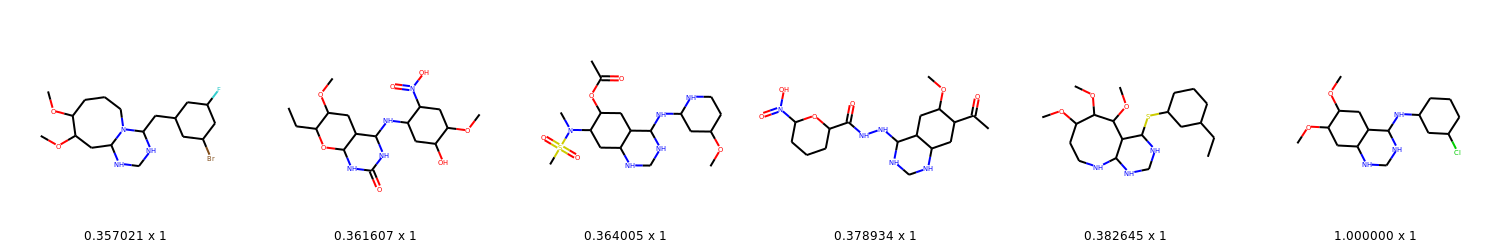

max score: 0.3826
From /home/fc334/miniconda2/envs/sci3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
From /home/fc334/miniconda2/envs/sci3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
From /home/fc334/miniconda2/envs/sci3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
ego_gp grammar: #interfaces:   518   #cores:   401   #core-interface-pairs:   823  #

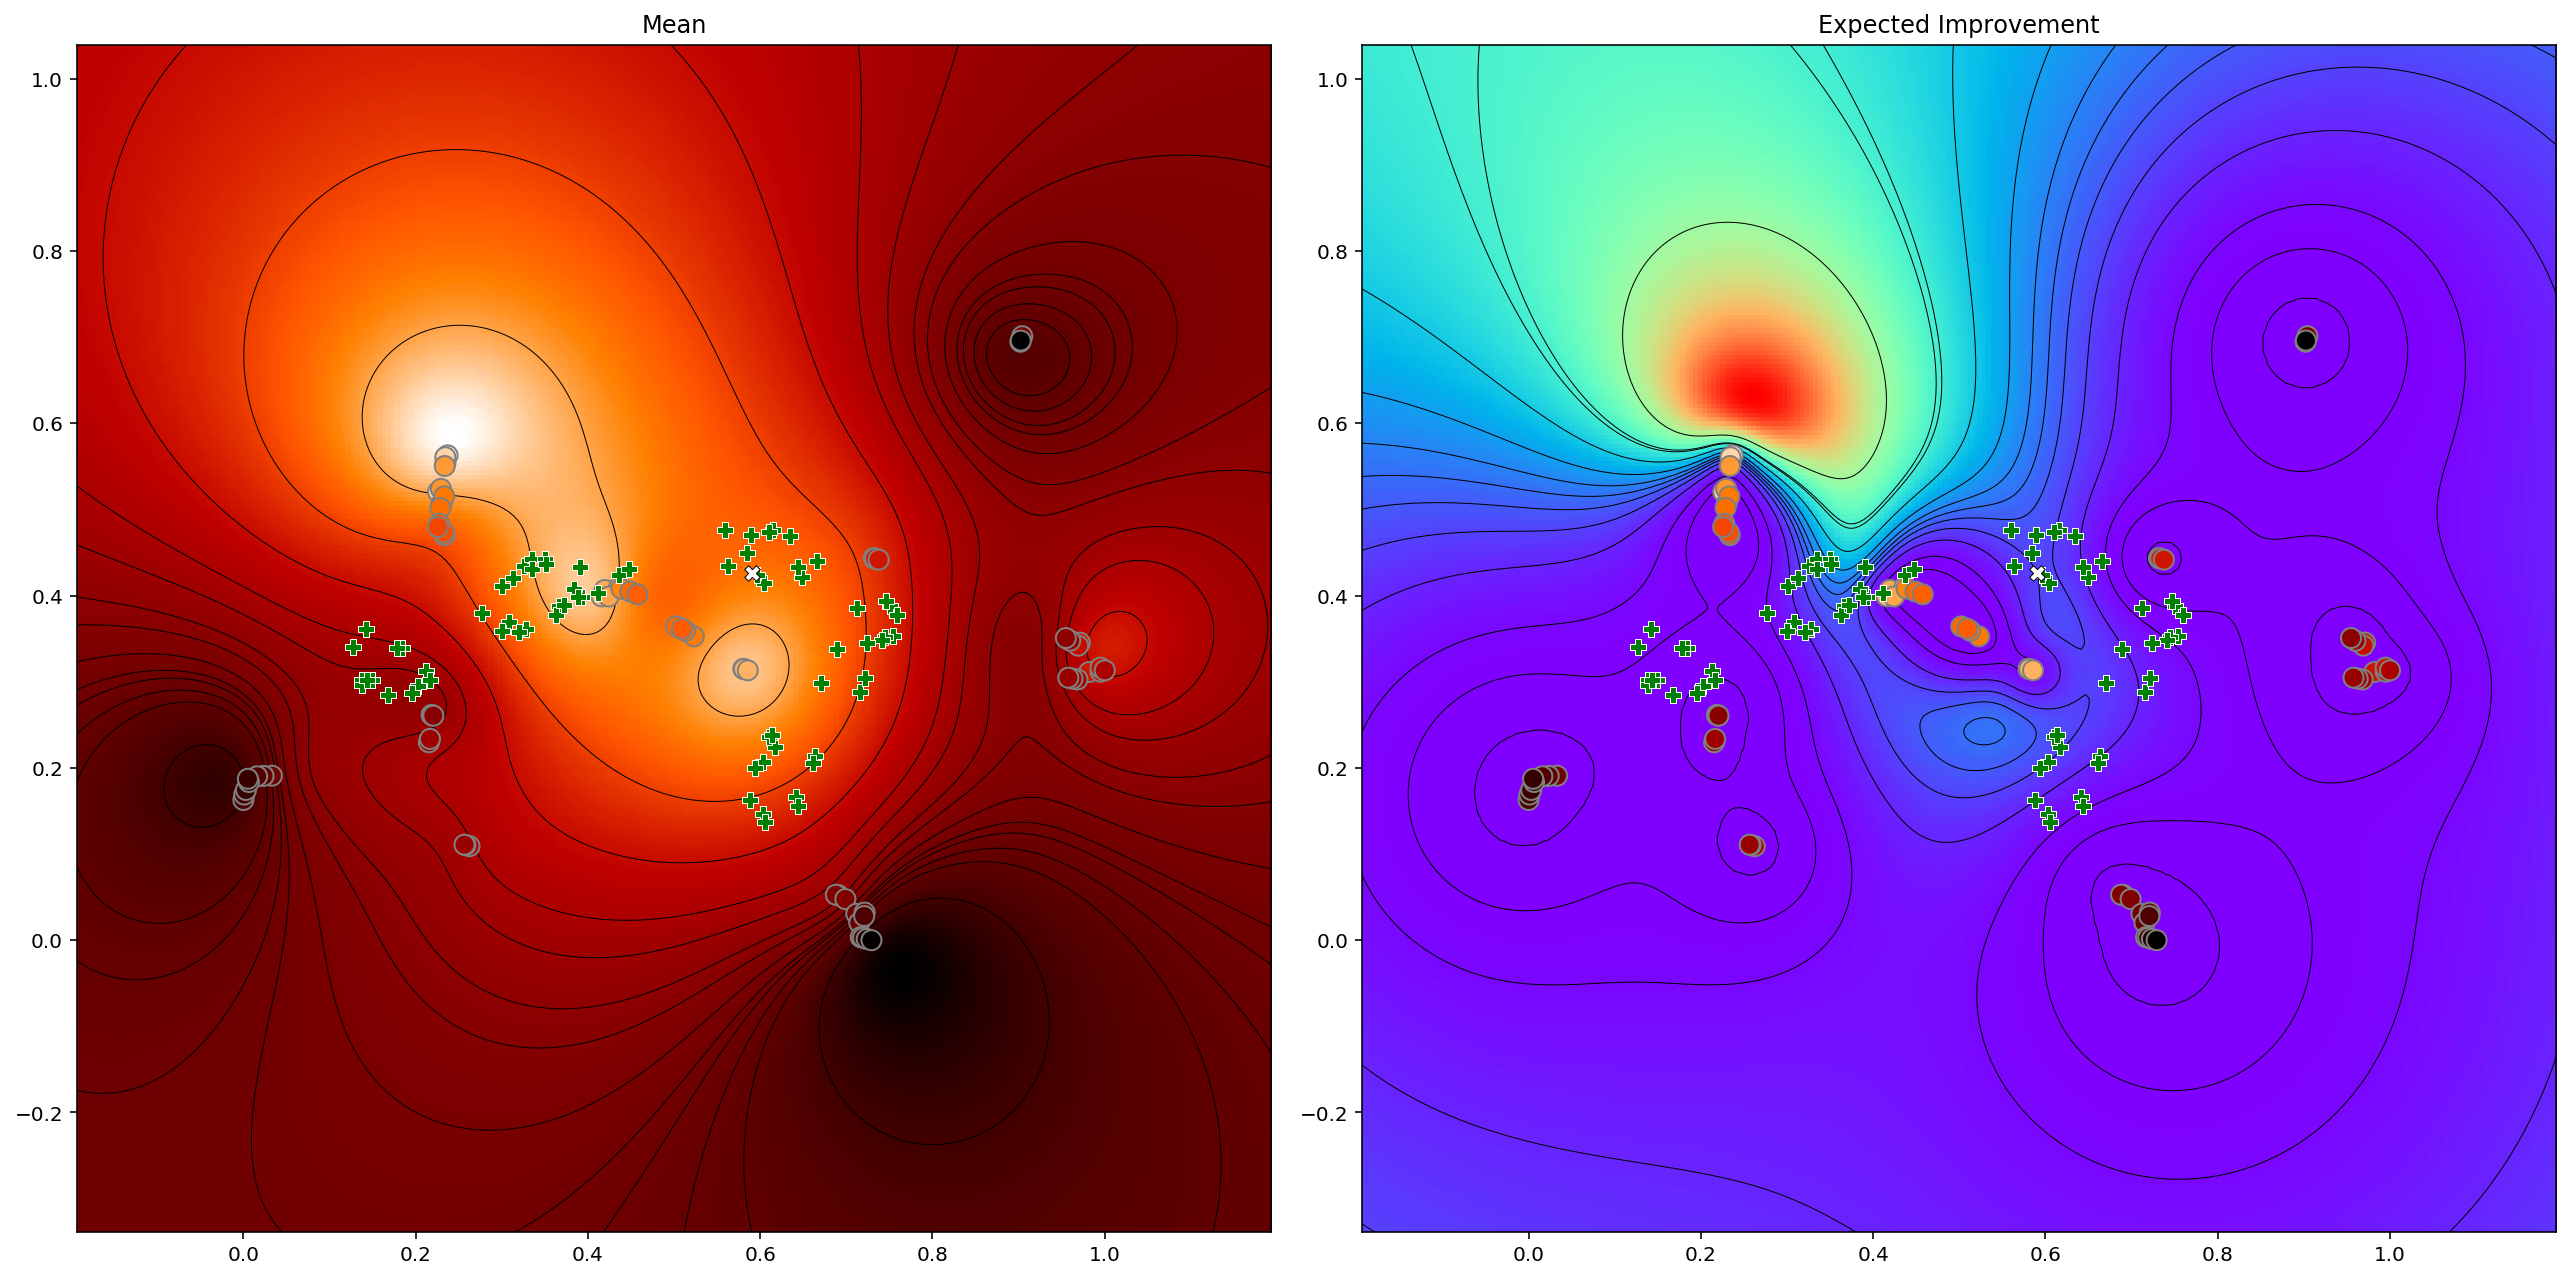

...elapsed 32.2 secs [=0.5 mins]
--------------------------------------------------------------------------------
 iter: 1   # graphs: 83 (621.5 secs) [=10.4 mins]



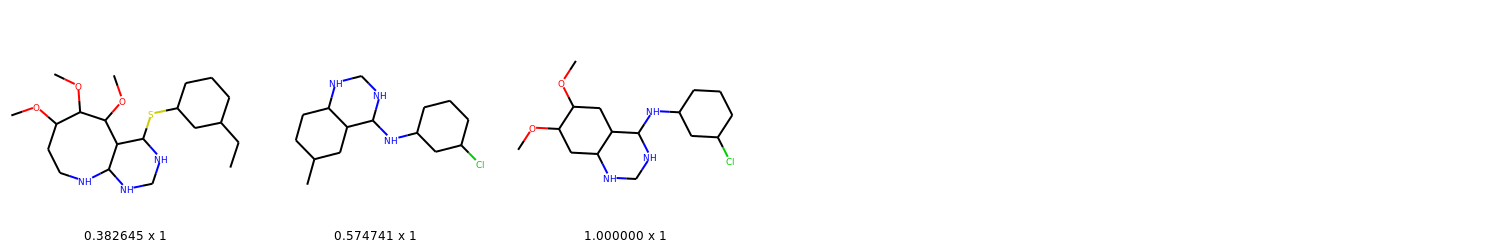

max score: 0.5747
gp grammar: #interfaces:  2045   #cores:    83   #core-interface-pairs:  2771  #production-rules:  3812
Displaying expected improvement for 83 instances in 2D


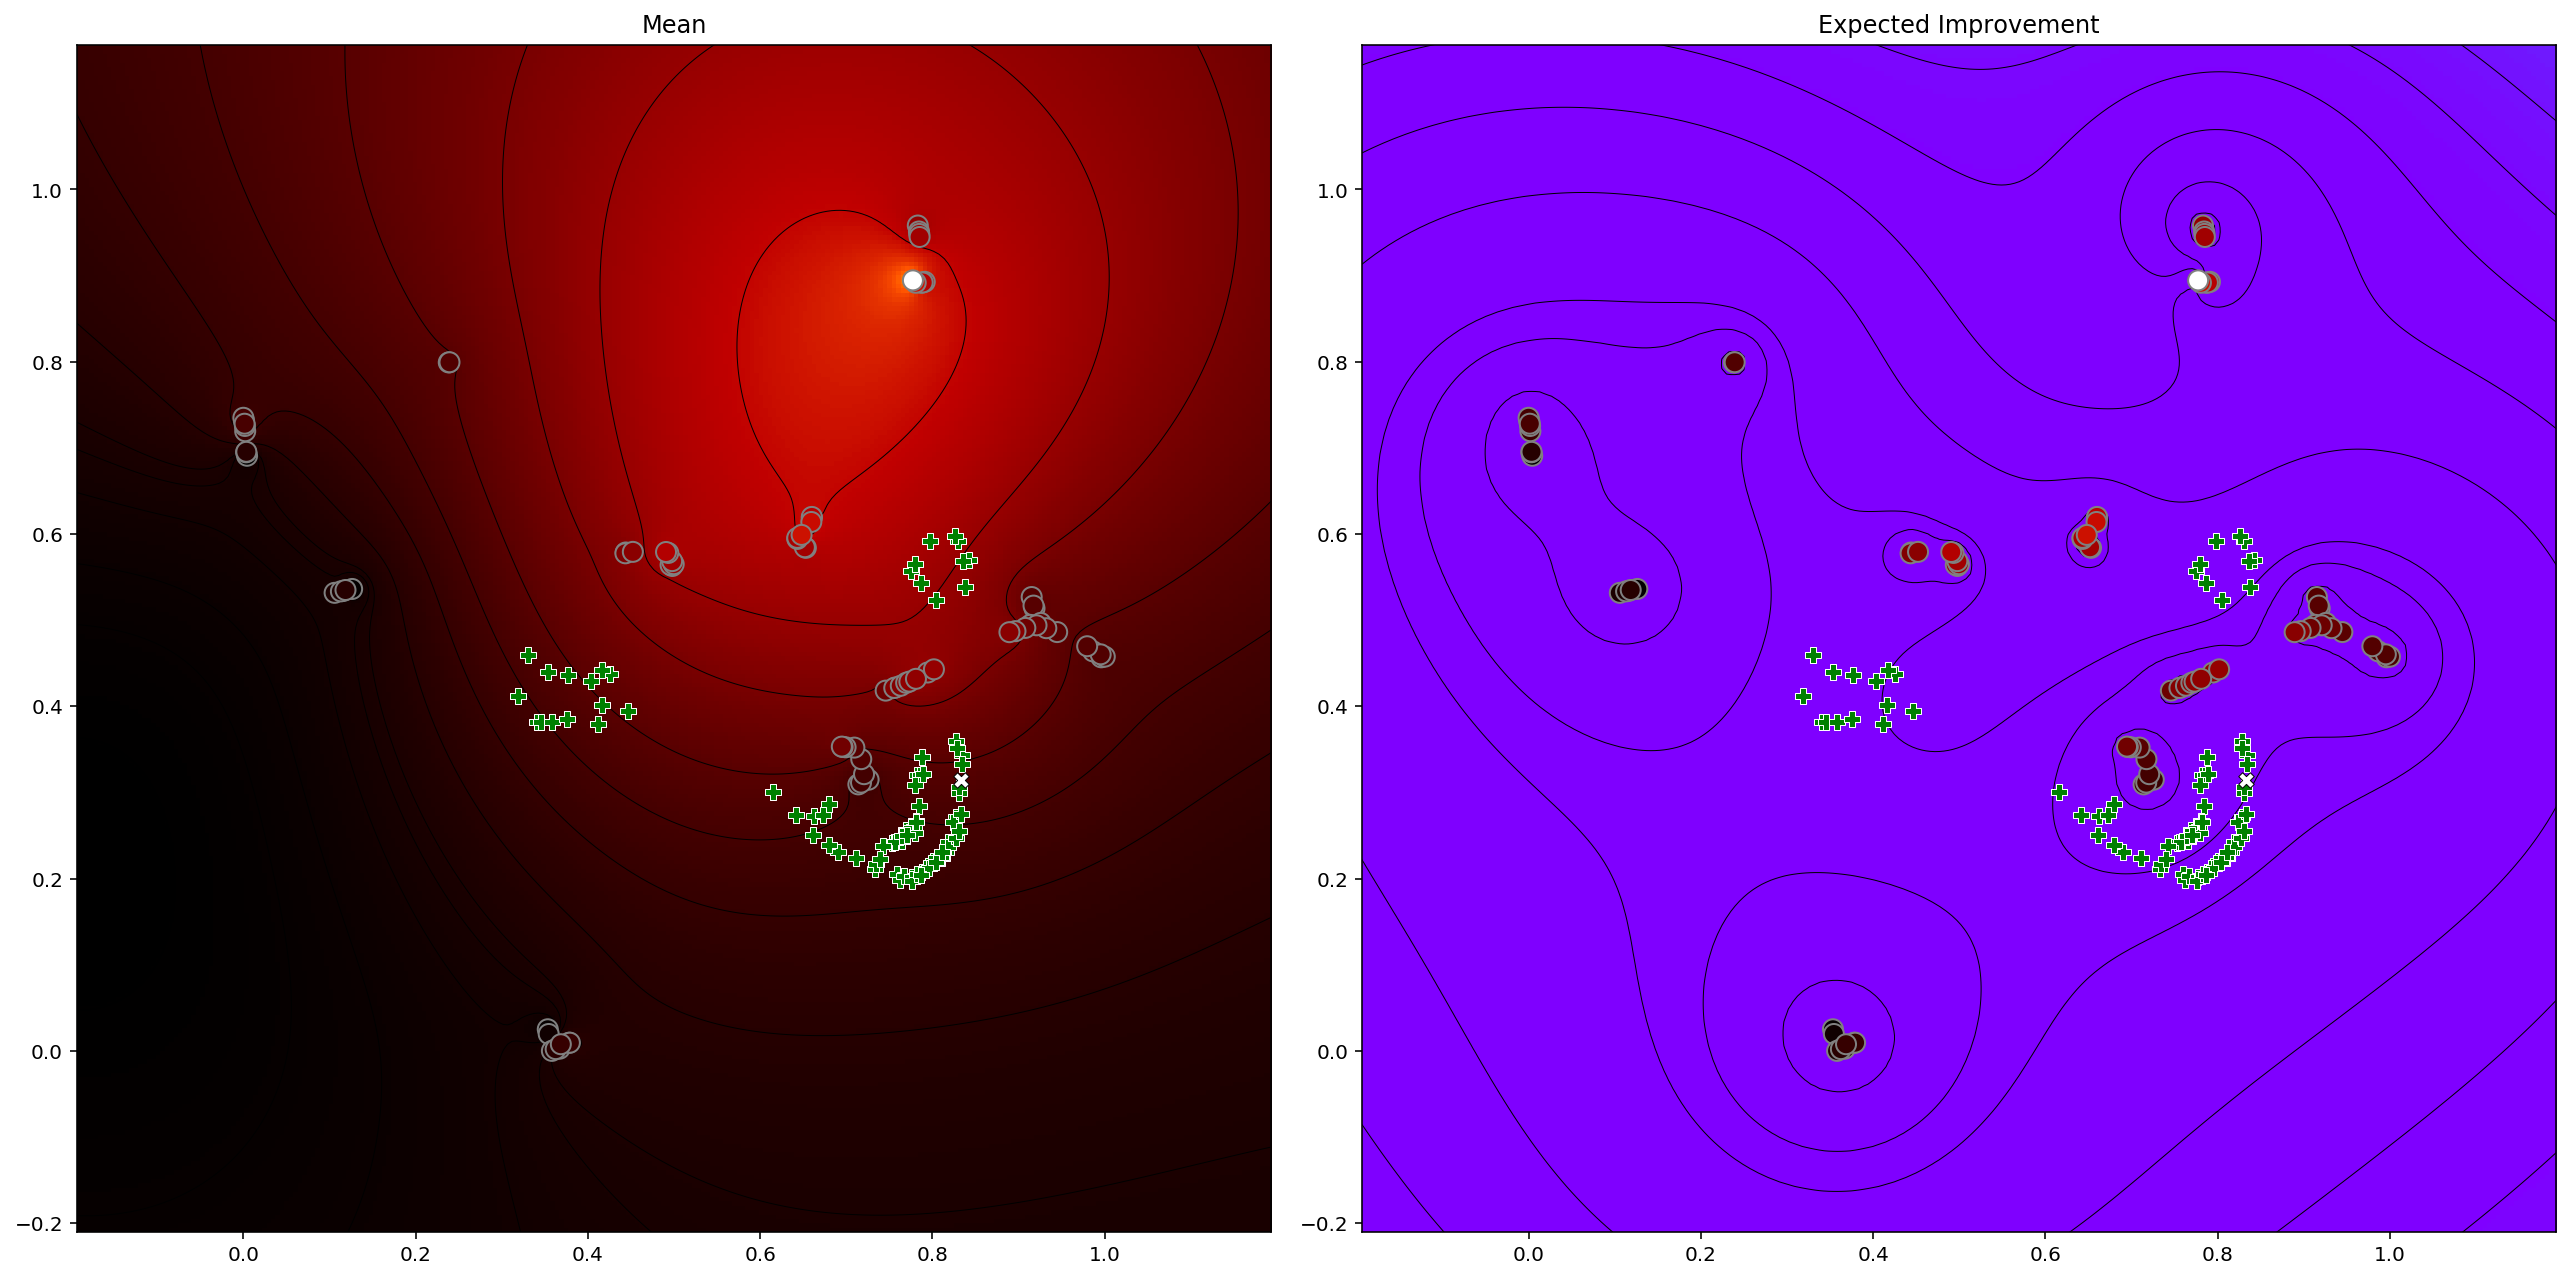

...elapsed 33.9 secs [=0.6 mins]
--------------------------------------------------------------------------------
 iter: 2   # graphs: 103 (1287.5 secs) [=21.5 mins]



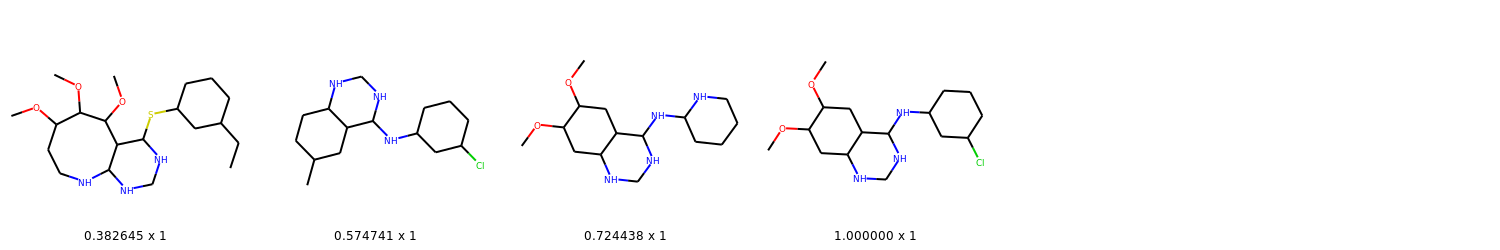

max score: 0.7244
ego_gp grammar: #interfaces:   515   #cores:   476   #core-interface-pairs:   884  #production-rules:  4058
Displaying expected improvement for 103 instances in 2D


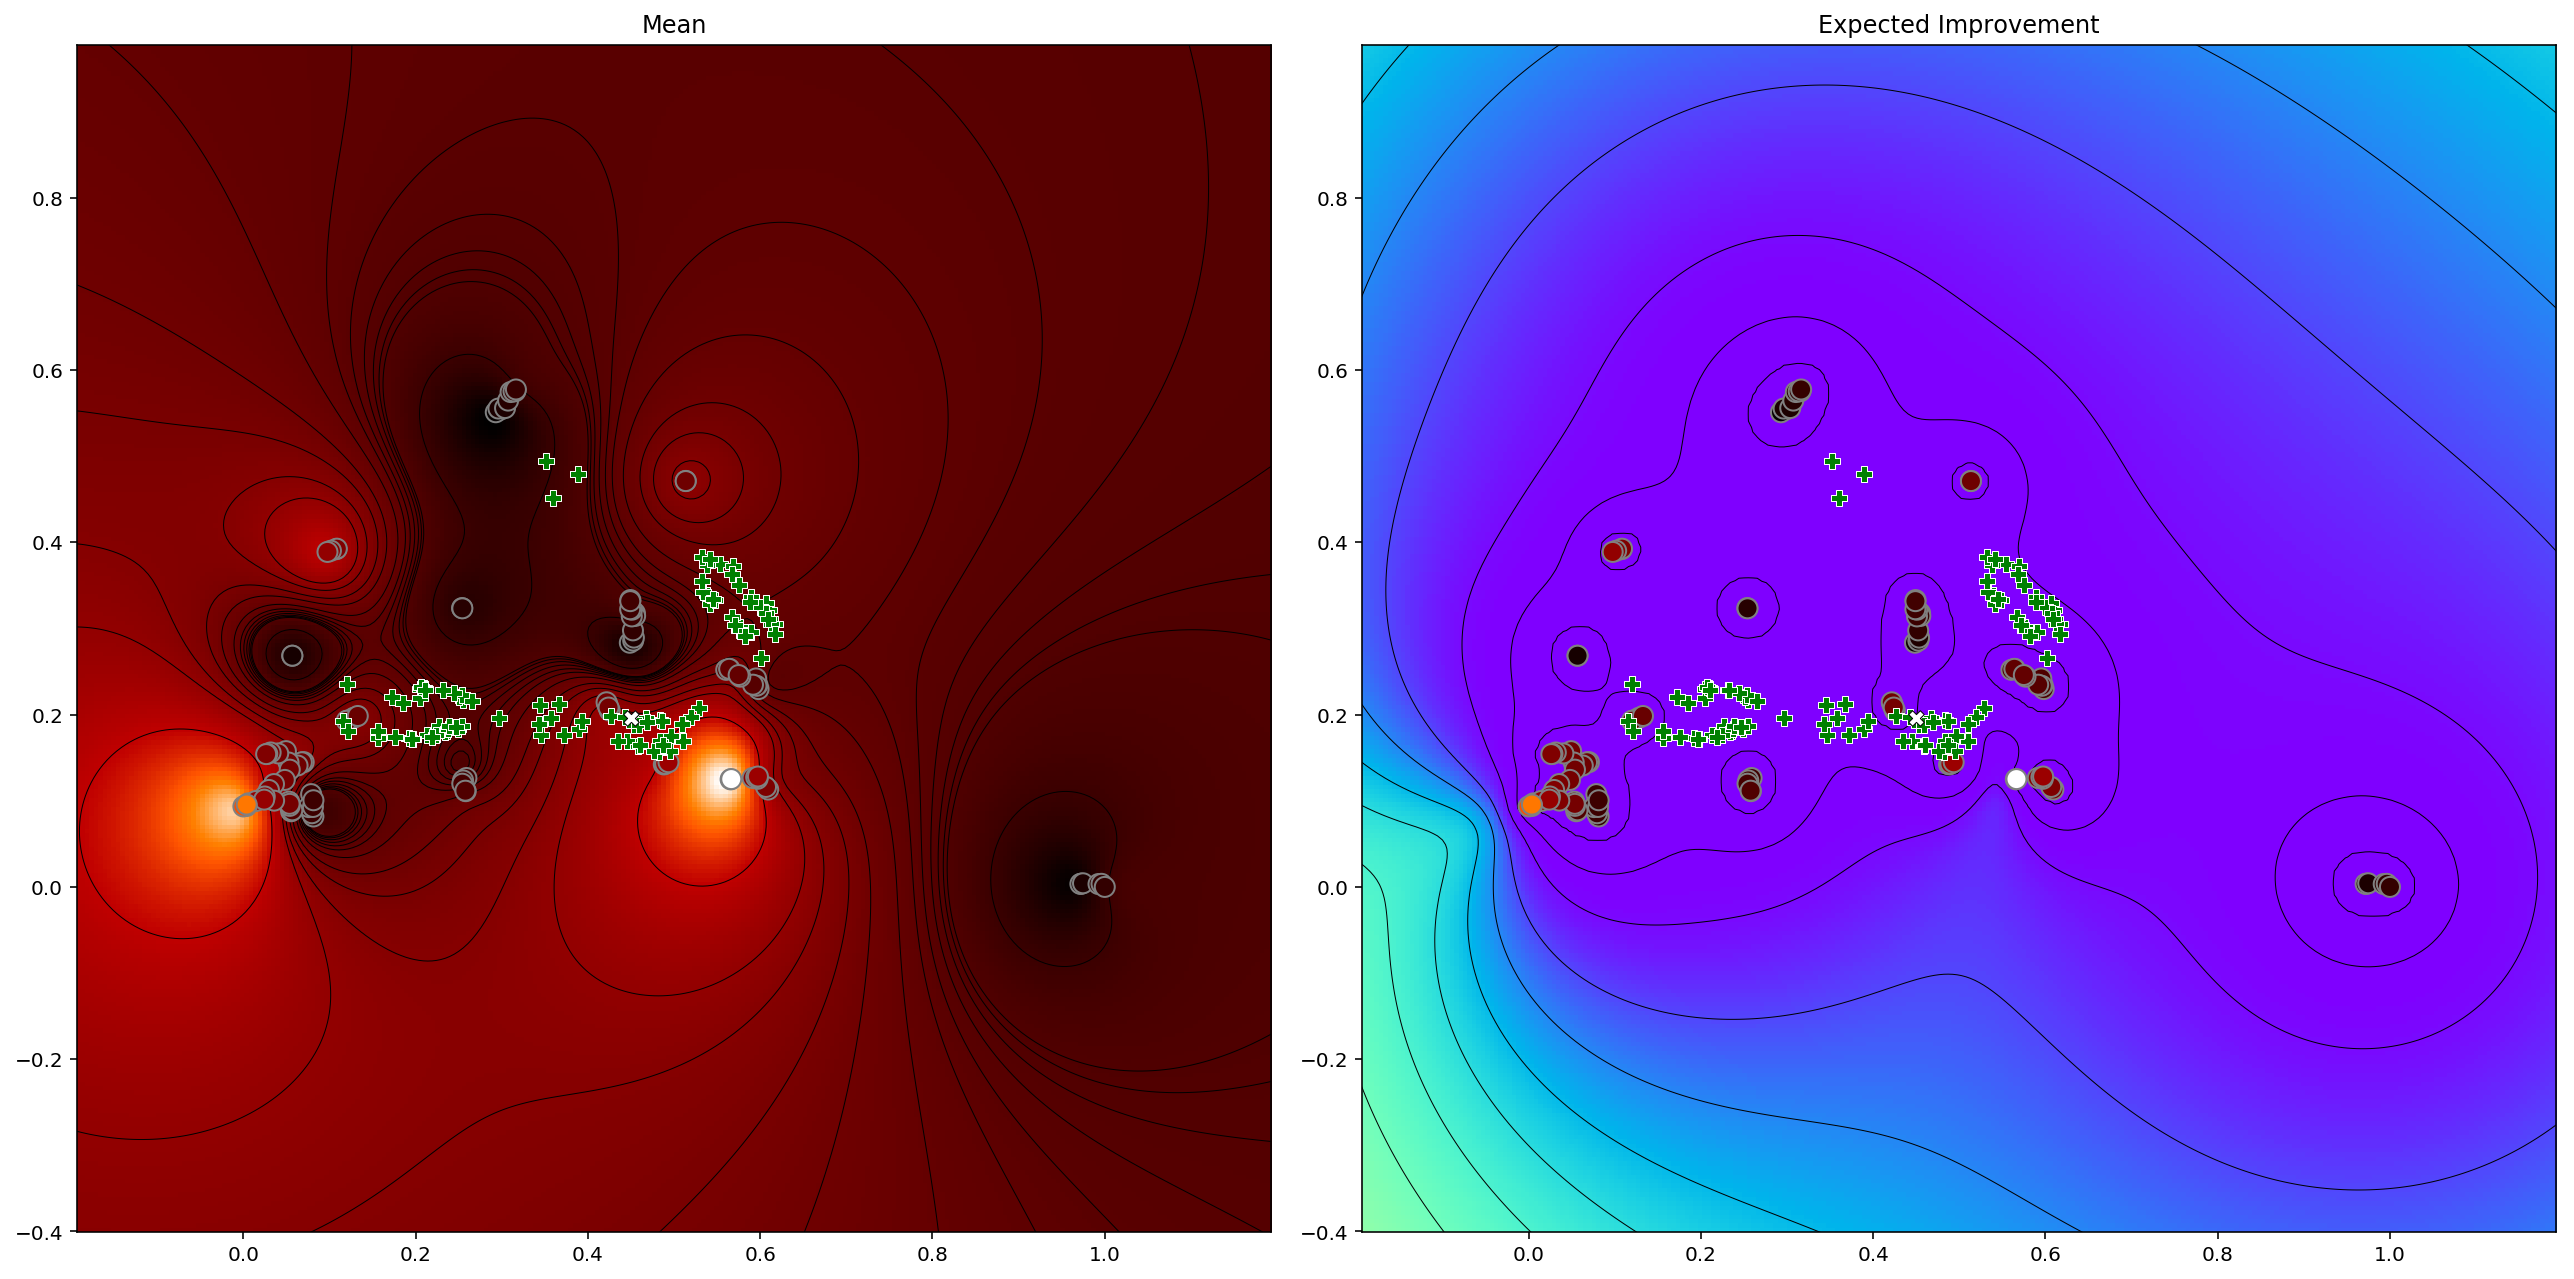

...elapsed 41.2 secs [=0.7 mins]
--------------------------------------------------------------------------------
 iter: 3   # graphs: 115 (2961.5 secs) [=49.4 mins]



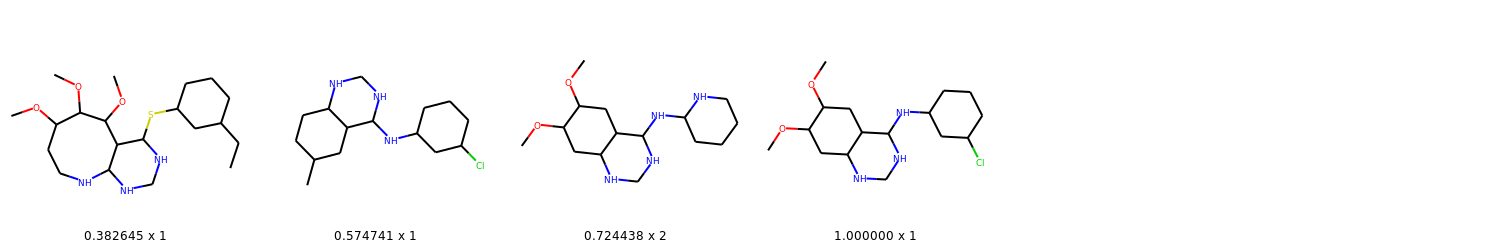

max score: 0.7244
gp grammar: #interfaces:  2045   #cores:    83   #core-interface-pairs:  2771  #production-rules:  3812
Displaying expected improvement for 115 instances in 2D


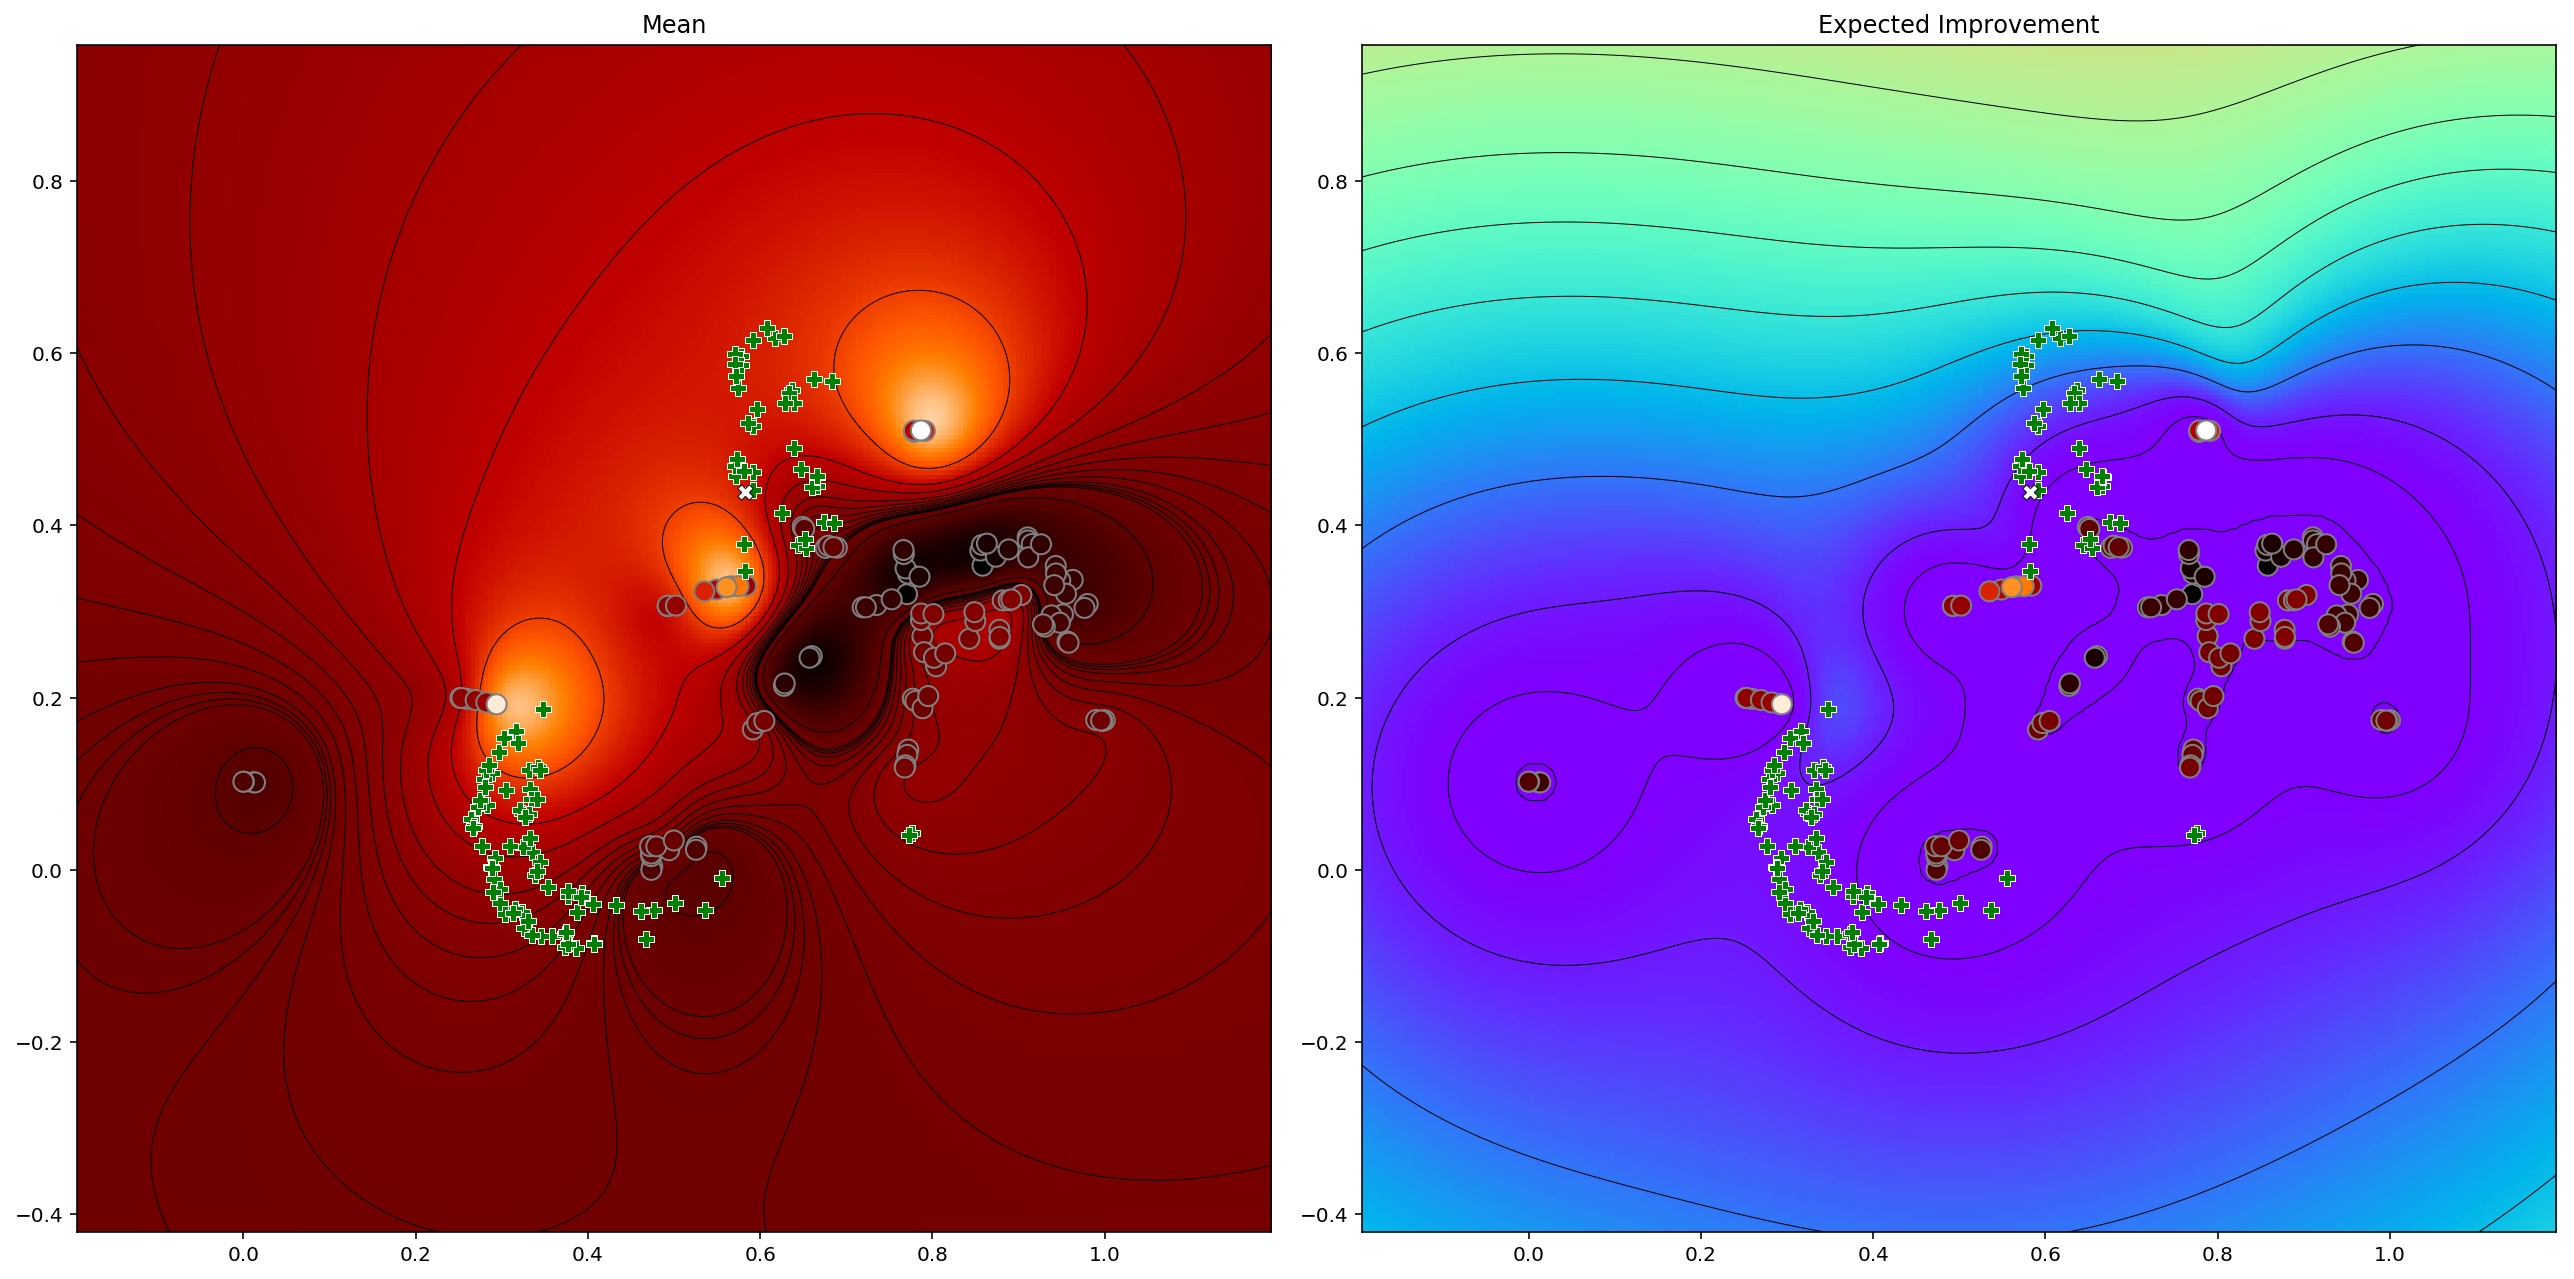

...elapsed 45.3 secs [=0.8 mins]
--------------------------------------------------------------------------------
 iter: 4   # graphs: 134 (5678.2 secs) [=94.6 mins]



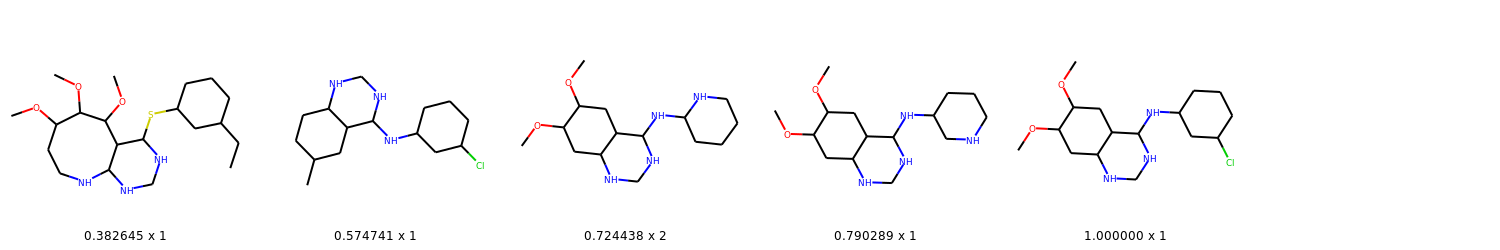

max score: 0.7903
ego_gp grammar: #interfaces:   495   #cores:   465   #core-interface-pairs:   896  #production-rules:  5370
Displaying expected improvement for 134 instances in 2D


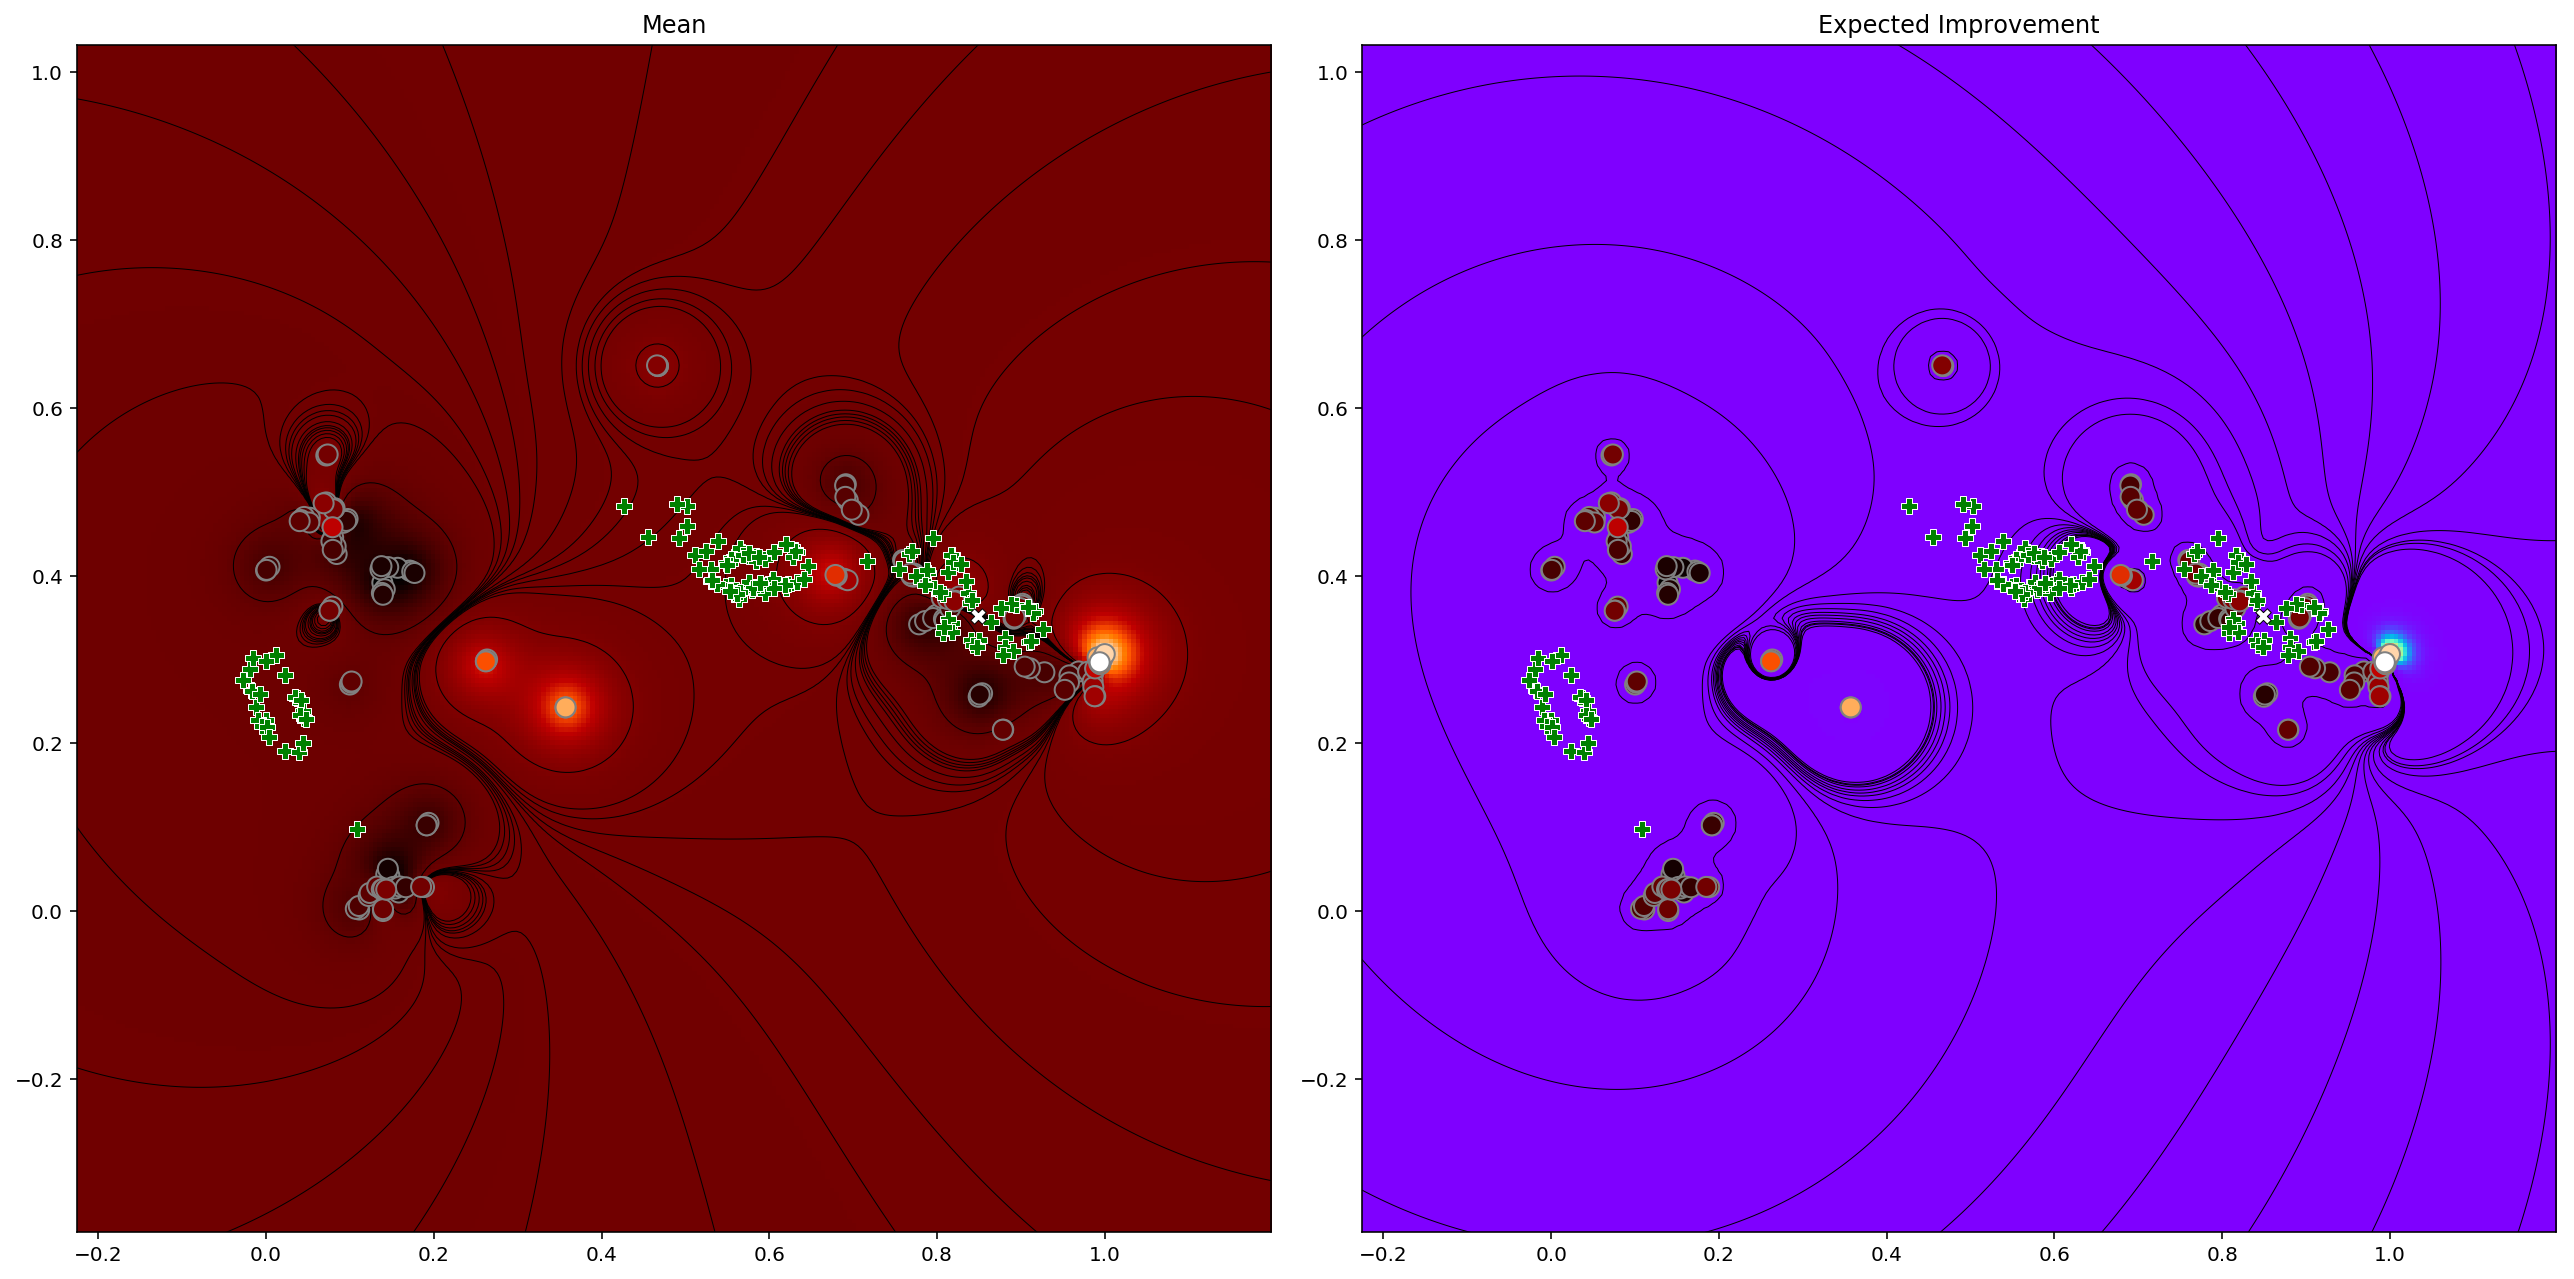

...elapsed 49.8 secs [=0.8 mins]
--------------------------------------------------------------------------------
 iter: 5   # graphs: 154 (4588.0 secs) [=76.5 mins]



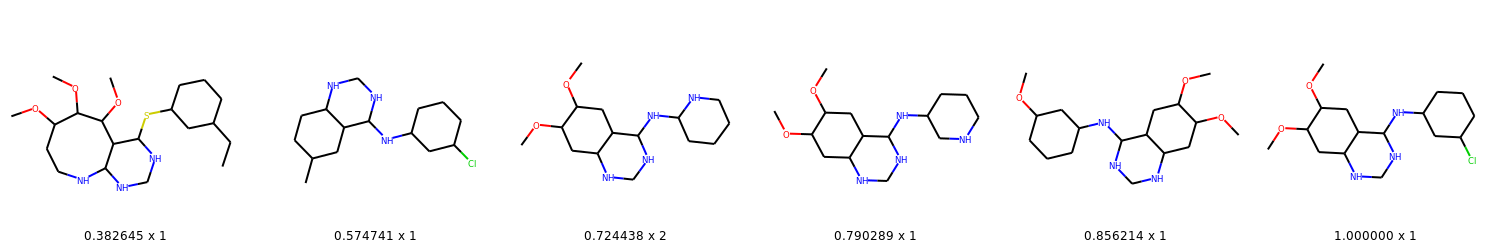

max score: 0.8562
gp grammar: #interfaces:  2045   #cores:    83   #core-interface-pairs:  2771  #production-rules:  3812
Displaying expected improvement for 154 instances in 2D


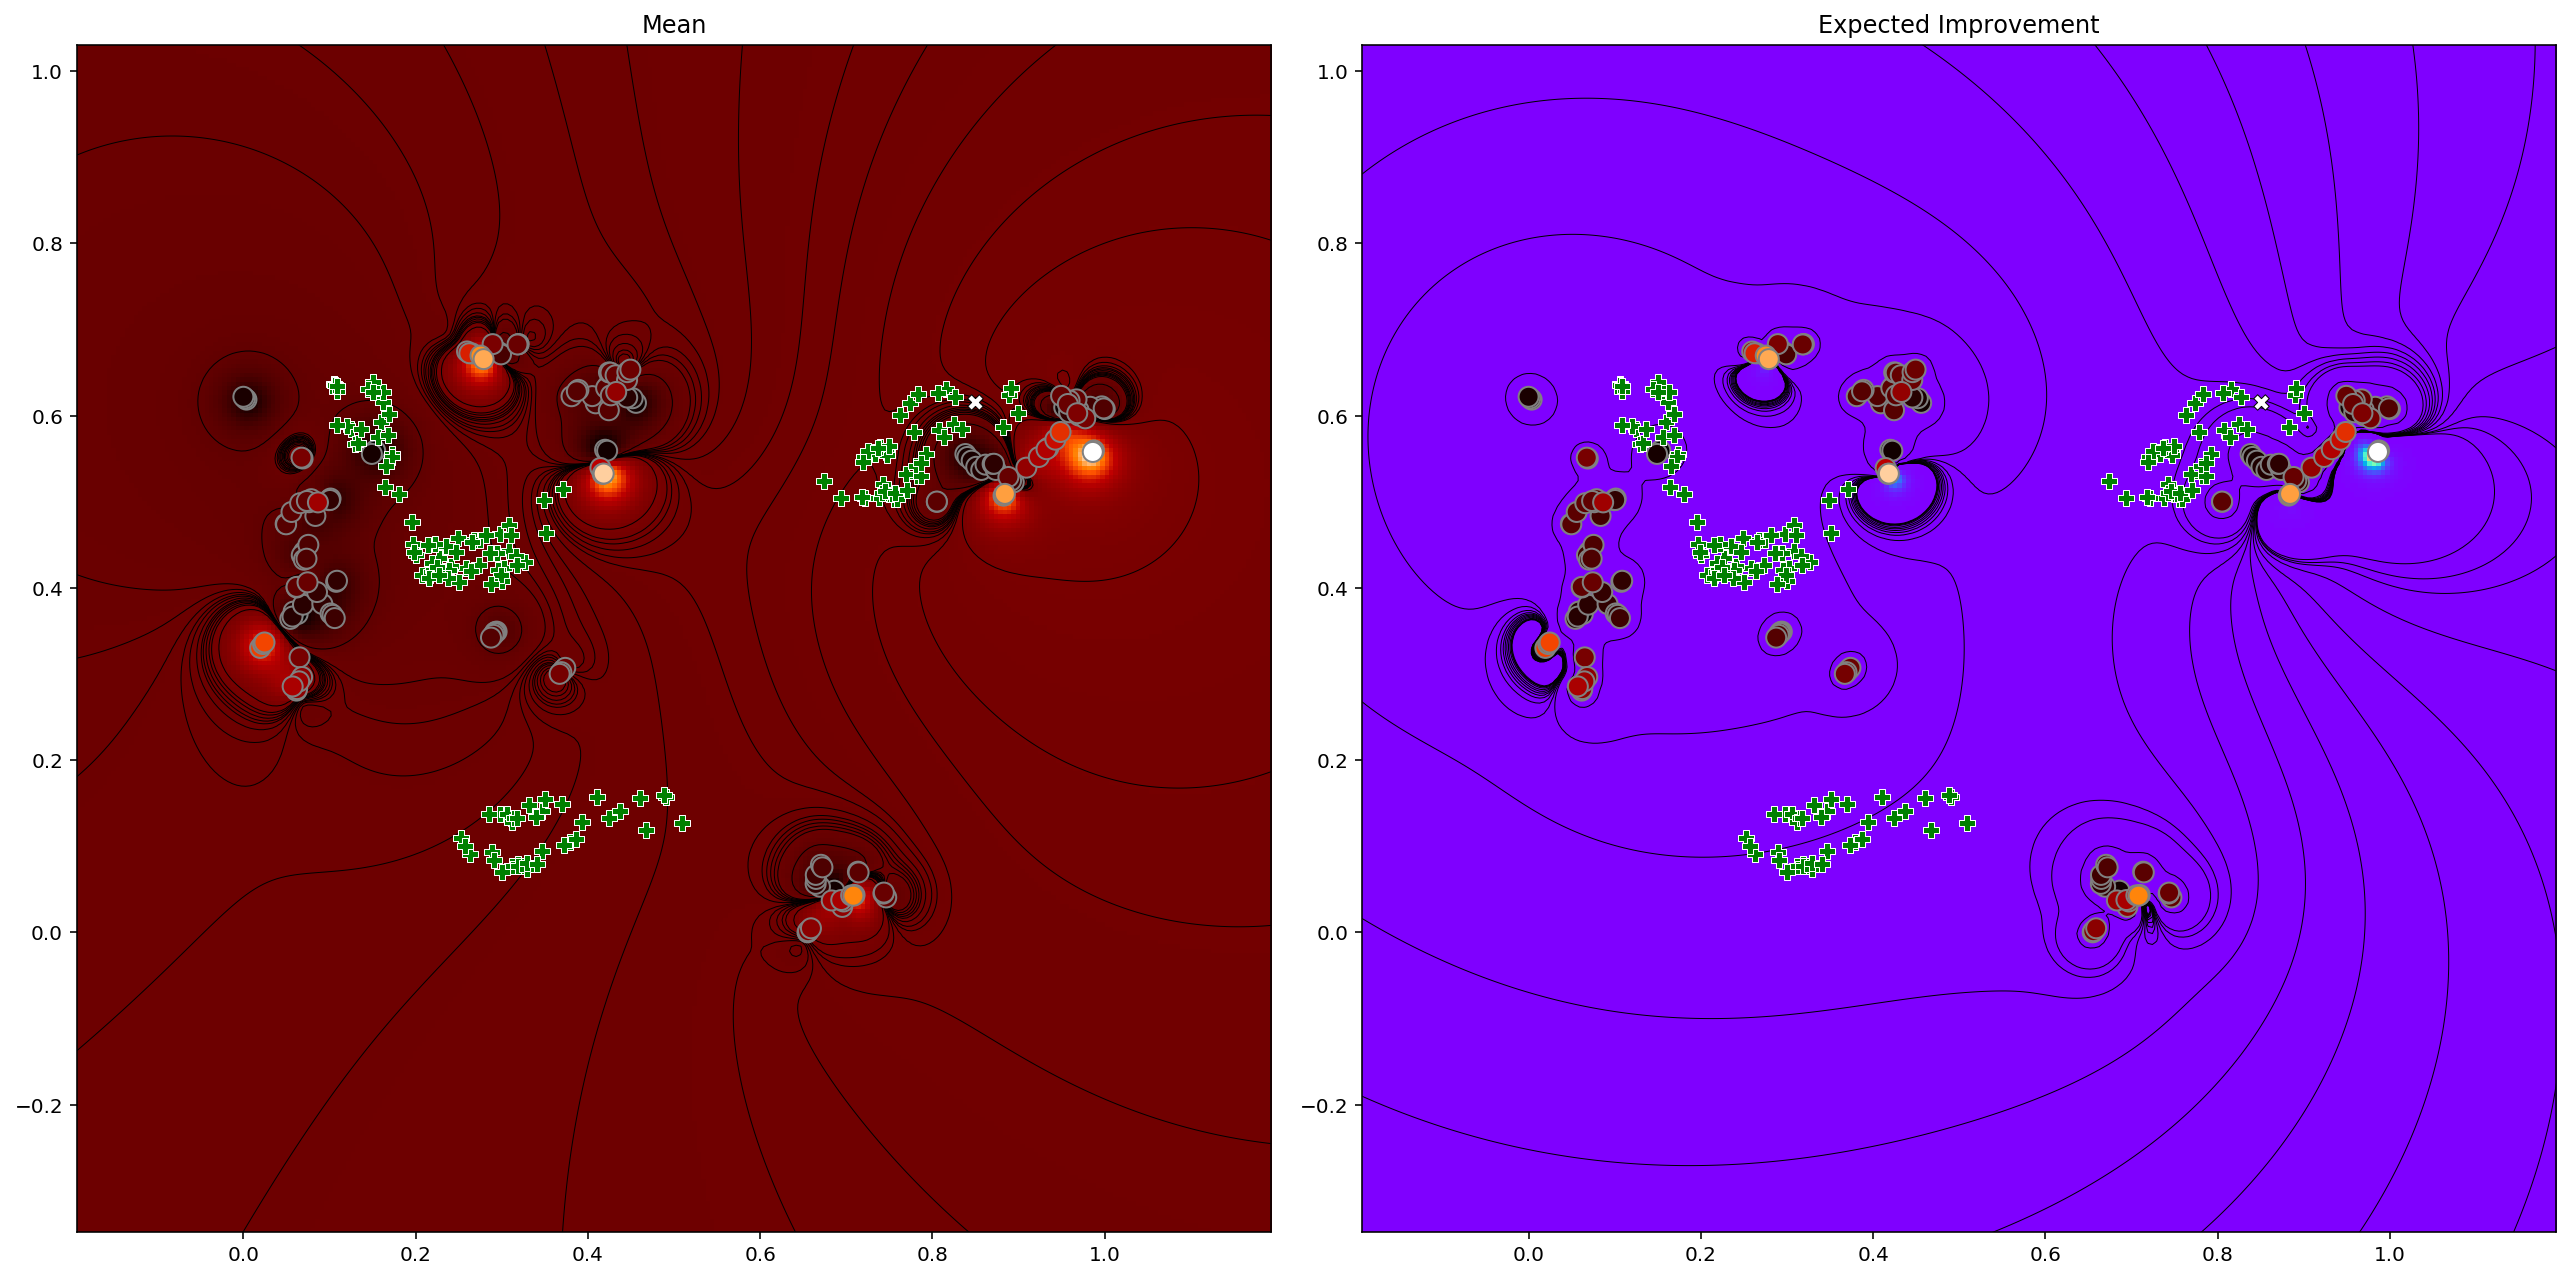

...elapsed 52.9 secs [=0.9 mins]
--------------------------------------------------------------------------------
 iter: 6   # graphs: 164 (8555.0 secs) [=142.6 mins]



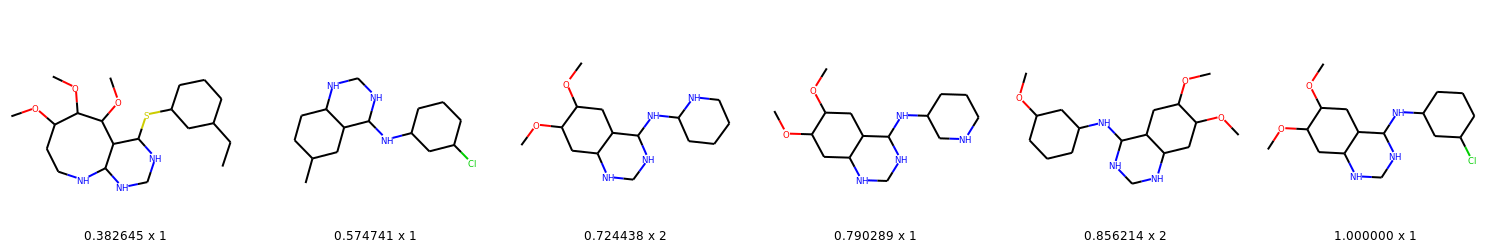

max score: 0.8562
ego_gp grammar: #interfaces:   545   #cores:   505   #core-interface-pairs:   962  #production-rules:  7670
Displaying expected improvement for 164 instances in 2D


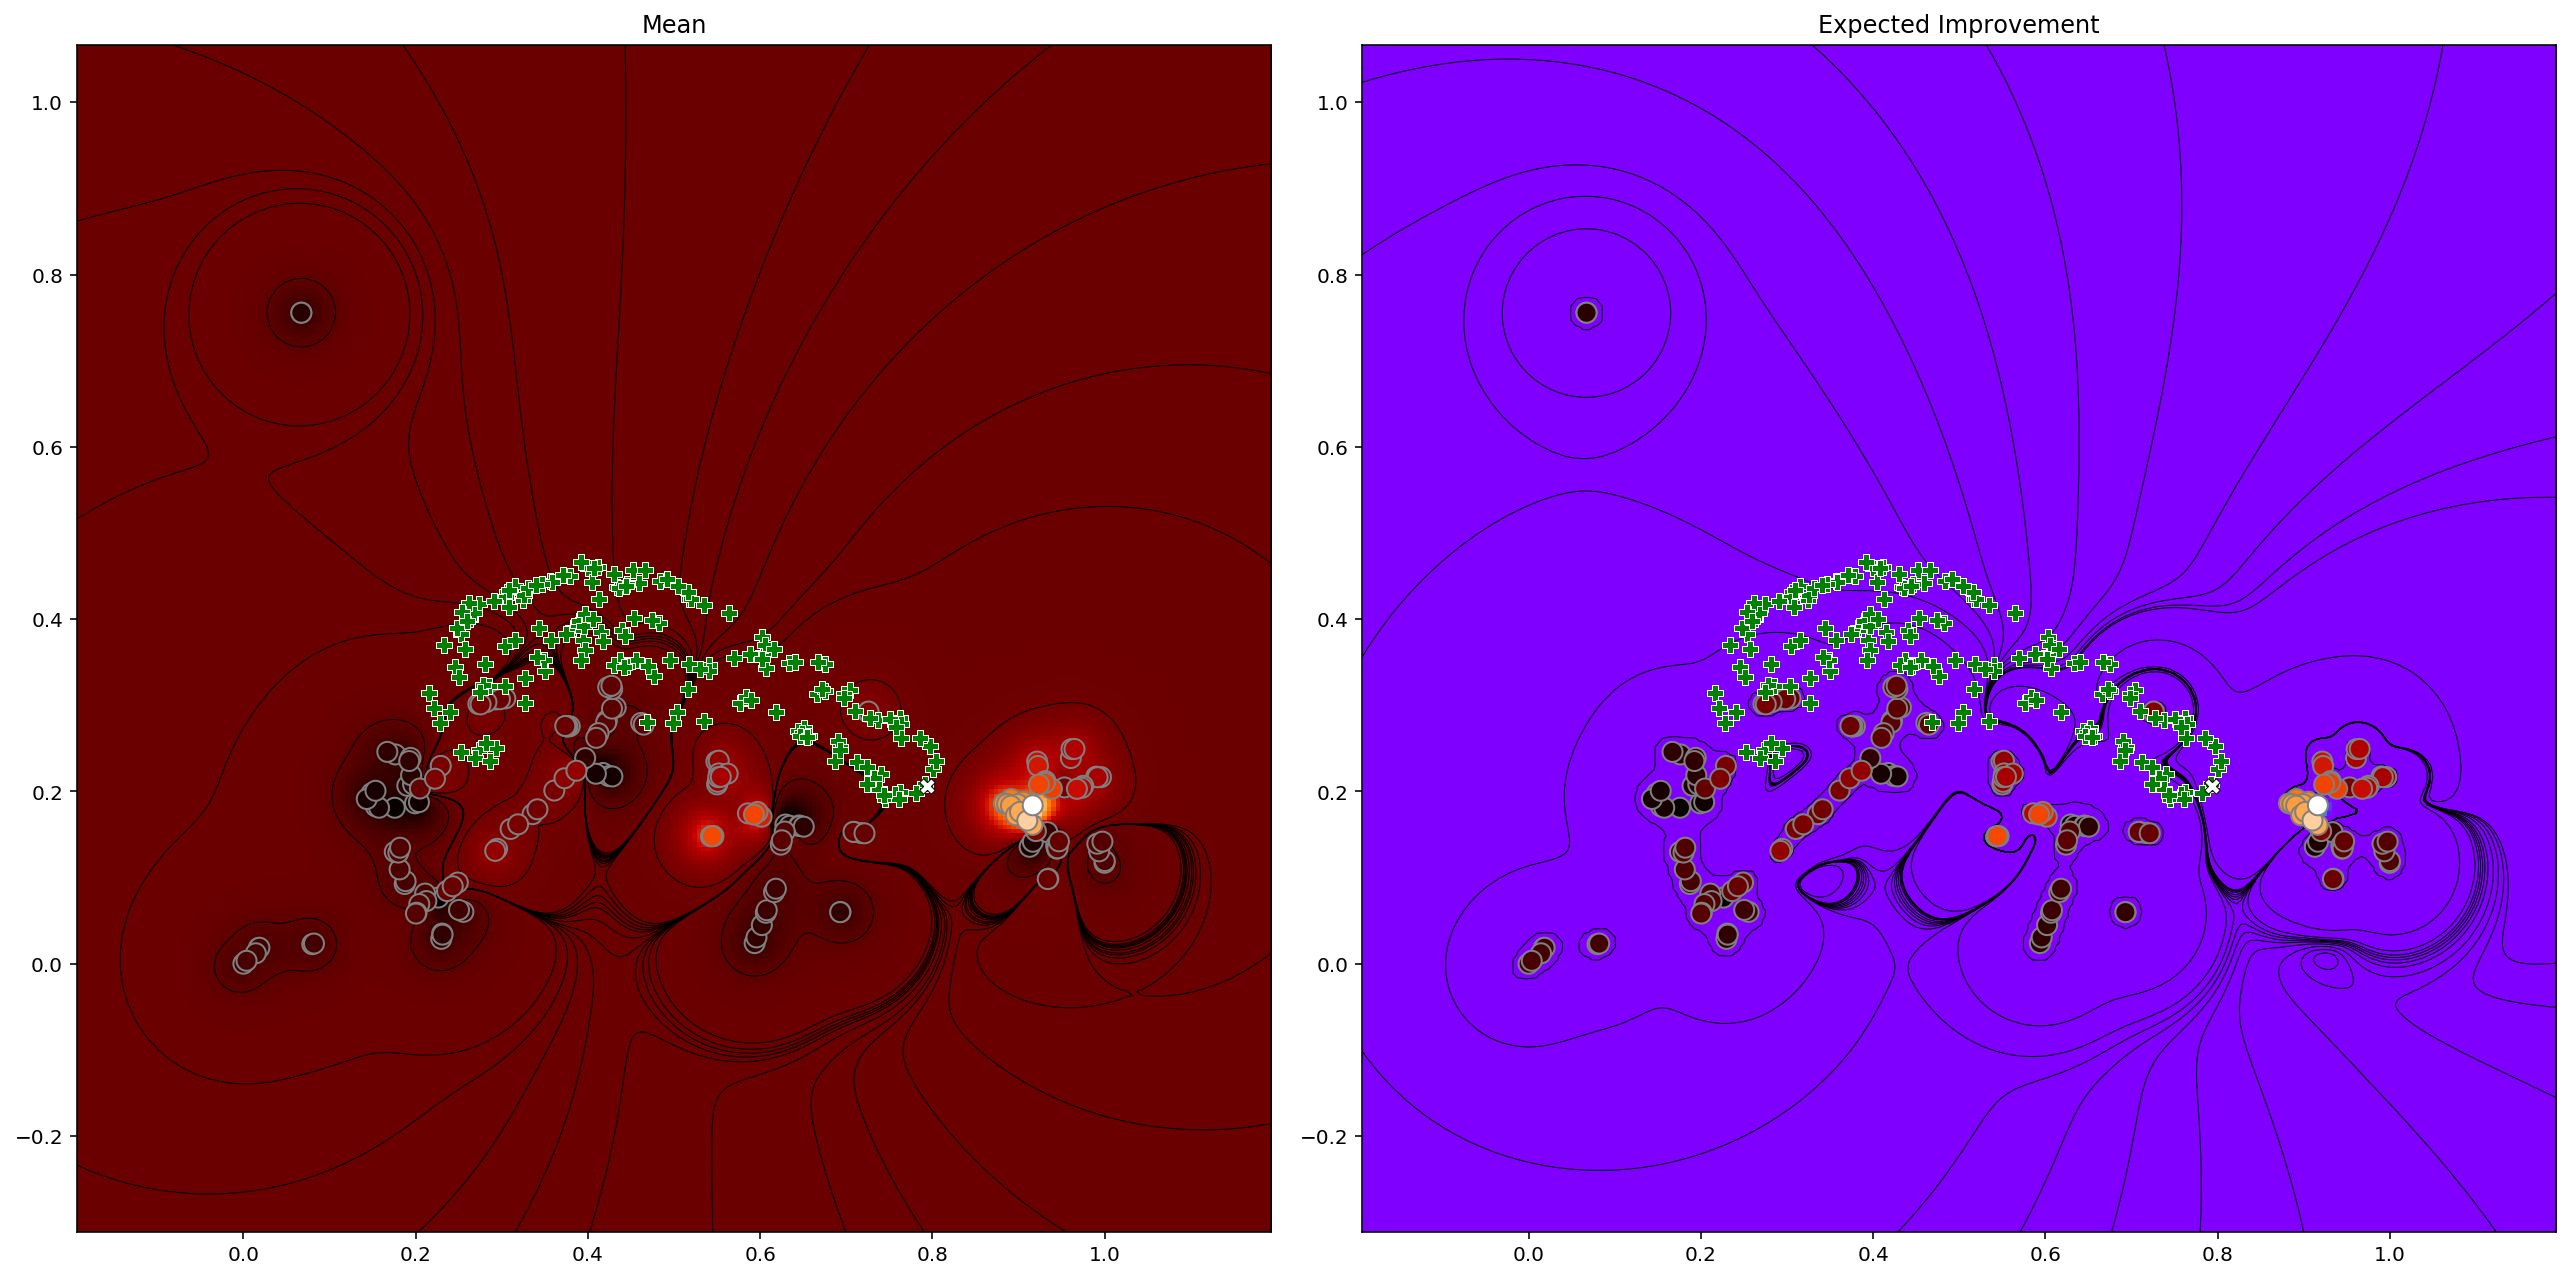

...elapsed 59.6 secs [=1.0 mins]
--------------------------------------------------------------------------------
 iter: 7   # graphs: 175 (5592.6 secs) [=93.2 mins]



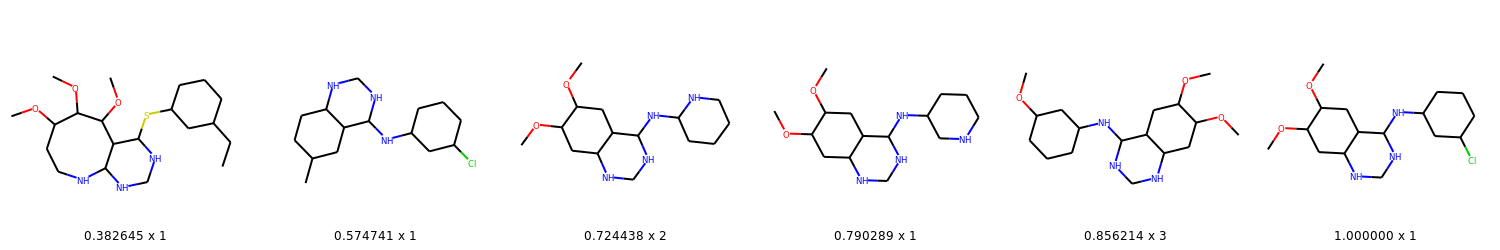

max score: 0.8562
gp grammar: #interfaces:  2045   #cores:    83   #core-interface-pairs:  2771  #production-rules:  3812


In [ ]:
%%time
all_results = c_run_experiments(threshold)
display_results(threshold, all_results)

---

Results summary:

- Working with dataset with 0.40 similarity threshold
- Working with a budget of 30 instances
- Beam search of size 10 instances
- Max n iter 40
- n components 4

Avg score: 0.930
________________________________________________________________________________
CPU times: user 3d 6h 40min 14s, sys: 3h 7min 34s, total: 3d 9h 47min 48s
Wall time: 21h 12min 19s